In [1]:
%reset -sf

import tensorflow as tf
print("Tensorflow:", tf.__version__)


# GPU(s) setups
gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        
        # Enable memory growth for the first GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        
        # Instead of enabling memory growth, set a memory limit
        memory_limit = 16_376 # Set the memory limit in MB
        # memory_limit = -1
        if memory_limit >= 0:
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)]
            )
            
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

2024-12-05 07:16:24.540196: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-05 07:16:24.561620: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow: 2.16.1
1 Physical GPUs, 1 Logical GPU


2024-12-05 07:16:25.285278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16376 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [2]:
import sys
import os
import glob

HOME_PATH = os.path.abspath("..")
sys.path.insert(0, HOME_PATH + "/qe")

import atlas_plot as ap

plot = ap.Plotter()

import pandas as pd
import numpy as np
import scipy as sp

from matplotlib import pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # suppress tensorflow imformation messages

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


SEED = 42  # set random seed (global variable)
GEV = 1e-3

In [3]:
import full_data as data

# reco
lead_lep = data.Lead_lep()
sublead_lep = data.Sublead_lep()
met = data.Met()

# truth
truth_lead_lep = data.Truth_lead_lep()
truth_sublead_lep = data.Truth_sublead_lep()
Truth_dilep = data.Truth_dilep()
truth_met = data.Truth_met()

# target Ws
w_lead = data.Lead_w()
w_sublead = data.Sublead_w()

In [4]:
# # define preselection cuts

# cut_pre_pt_lead = lead_lep.pt > 22
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
# cut_pre_pt_sub = sublead_lep.pt > 15
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
# cut_pre_dilep_m = (
#     np.sqrt(
#         np.square(lead_lep.energy + sublead_lep.energy)
#         - np.square(lead_lep.px + sublead_lep.px)
#         - np.square(lead_lep.py + sublead_lep.py)
#         - np.square(lead_lep.pz + sublead_lep.pz)
#     )
#     > 10
# )
# print(len(lead_lep.energy) - np.sum(cut_pre_dilep_m * 1))
# cut_pre_pt_miss = met.pt > 20
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_miss * 1))
# PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
# print(len(lead_lep.energy) - np.sum(PRE_CUT * 1))
# del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

# define preselection cuts

cut_pre_pt_lead = lead_lep.pt > -9999
print(len(lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = sublead_lep.pt > -9999
print(len(lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.sqrt(
        np.square(lead_lep.energy + sublead_lep.energy)
        - np.square(lead_lep.px + sublead_lep.px)
        - np.square(lead_lep.py + sublead_lep.py)
        - np.square(lead_lep.pz + sublead_lep.pz)
    )
    > -9999
)
print(len(lead_lep.energy) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = met.pt > -9999
print(len(lead_lep.energy) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print(len(lead_lep.energy) - np.sum(PRE_CUT * 1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

0
0
0
0
0


In [5]:
## Observing variables

obs_kin = np.column_stack(
    (
        lead_lep.px,
        lead_lep.py,
        # lead_lep.pz,
        # lead_lep.energy,
        np.log(lead_lep.energy),
        # np.log(lead_lep.pt),
        lead_lep.eta,
        # lead_lep.phi,
        sublead_lep.px,
        sublead_lep.py,
        # sublead_lep.pz,
        # sublead_lep.energy,
        np.log(sublead_lep.energy),
        # np.log(sublead_lep.pt),
        sublead_lep.eta,
        # sublead_lep.phi,
        met.px,
        met.py,
        # met.pt,
        # met.phi,
        # dilep.px,
        # dilep.py,
        # dilep.pz,
        # np.log(dilep.energy),
        # dilep.pt,
        # dilep.eta,
        # dilep.phi,
        # dilep.m,
    )
)[PRE_CUT]

# weights
mc_weight = data.MC_weight()
mc_weight = mc_weight.w.to_numpy()[PRE_CUT]

# Kinematics of observing variables (inputs for training)
print("int_kin shape:", obs_kin.shape)
# print(print(obs_kin.describe()))
# obs_kin = obs_kin.to_numpy() # convert to numpy array

ROBUST_OBS = StandardScaler()
obs_kin = ROBUST_OBS.fit_transform(obs_kin)
print(type(obs_kin))

int_kin shape: (1008897, 10)
<class 'numpy.ndarray'>


In [6]:
## Interesting variables

w_lead_px = pd.DataFrame(w_lead.px[PRE_CUT])
w_lead_py = pd.DataFrame(w_lead.py[PRE_CUT])
w_lead_pz = pd.DataFrame(w_lead.pz[PRE_CUT])
w_lead_e = pd.DataFrame(w_lead.energy[PRE_CUT])
w_lead_log_e = pd.DataFrame(np.log(w_lead_e))
w_lead_sqrt_e = pd.DataFrame(np.sqrt(w_lead_e))
w_sublead_px = pd.DataFrame(w_sublead.px[PRE_CUT])
w_sublead_py = pd.DataFrame(w_sublead.py[PRE_CUT])
w_sublead_pz = pd.DataFrame(w_sublead.pz[PRE_CUT])
w_sublead_e = pd.DataFrame(w_sublead.energy[PRE_CUT])
w_sublead_log_e = pd.DataFrame(np.log(w_sublead_e))
w_sublead_sqrt_e = pd.DataFrame(np.sqrt(w_sublead_e))
w_lead_m = pd.DataFrame(w_lead.m[PRE_CUT])
w_sublead_m = pd.DataFrame(w_sublead.m[PRE_CUT])

# Kinematics of interesting variables (target for training)
int_kin = np.concatenate(
    [
        w_lead_px,
        w_lead_py,
        w_lead_pz,
        w_lead_e,
        w_sublead_px,
        w_sublead_py,
        w_sublead_pz,
        w_sublead_e,
        # np.square(w_lead_m) / np.mean(w_lead_m),
        # np.square(w_sublead_m) / np.mean(w_lead_m),
        # w_lead_m,
        # w_sublead_m,
    ],
    axis=-1,
)
print("int_kin shape:", int_kin.shape)
# int_kin = int_kin.to_numpy()  # convert to numpy array
print(type(int_kin))

int_kin shape: (1008897, 8)
<class 'numpy.ndarray'>


In [7]:
int_kin[:, 0:3].shape

(1008897, 3)

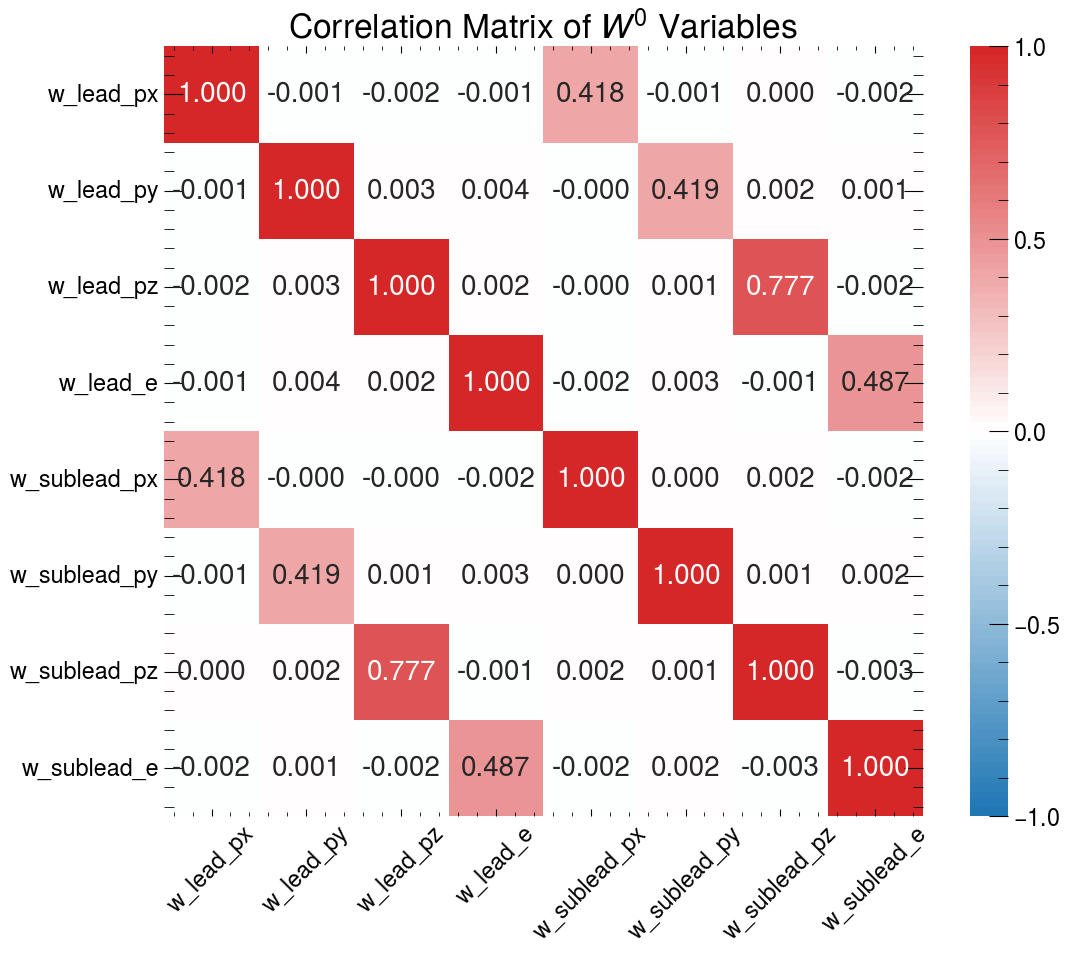

In [8]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Convert int_kin to a pandas DataFrame
int_kin_df = pd.DataFrame(
    int_kin[:, 0:],
    columns=[
        "w_lead_px",
        "w_lead_py",
        "w_lead_pz",
        "w_lead_e",
        "w_sublead_px",
        "w_sublead_py",
        "w_sublead_pz",
        "w_sublead_e",
    ],
)

# Calculate the correlation matrix
corr_matrix = int_kin_df.corr()

# Create a custom diverging color map with white at the center
colors = ["tab:blue", "white", "tab:red"]
n_bins = 100  # Number of bins in the color map
cmap_name = "custom_diverging"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".3f",
    cmap=custom_cmap,
    vmin=-1,
    vmax=1,
    center=0,
    cbar_kws={"ticks": [-1, -0.5, 0, 0.5, 1]},
    annot_kws={"size": 20},
)
plt.title("Correlation Matrix of $W^{0}$ Variables")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

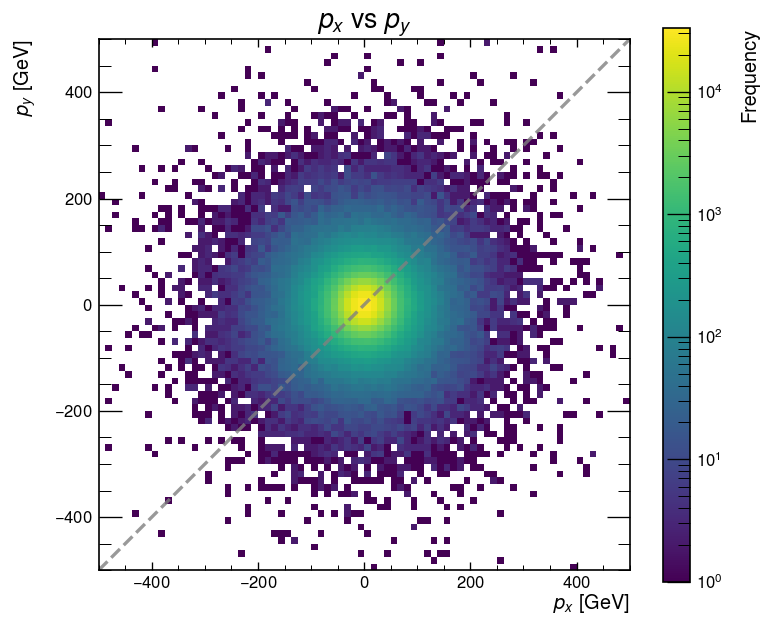

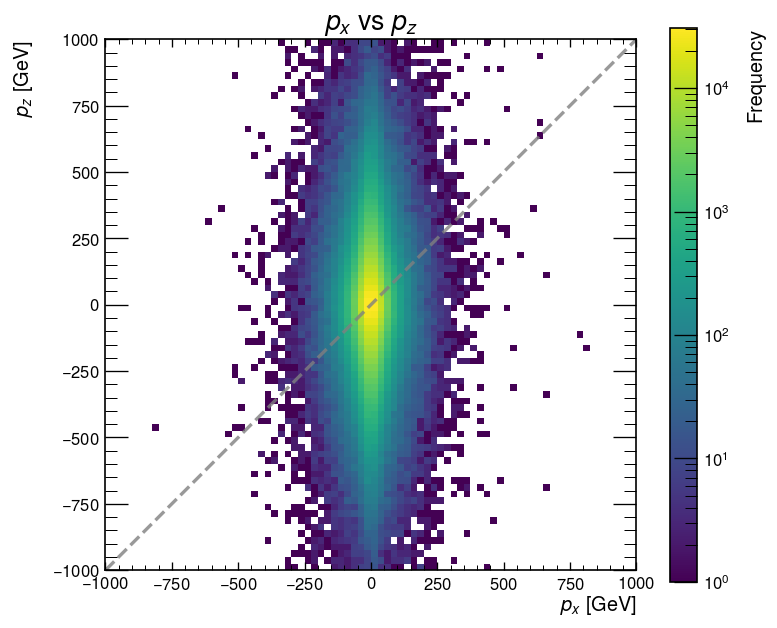

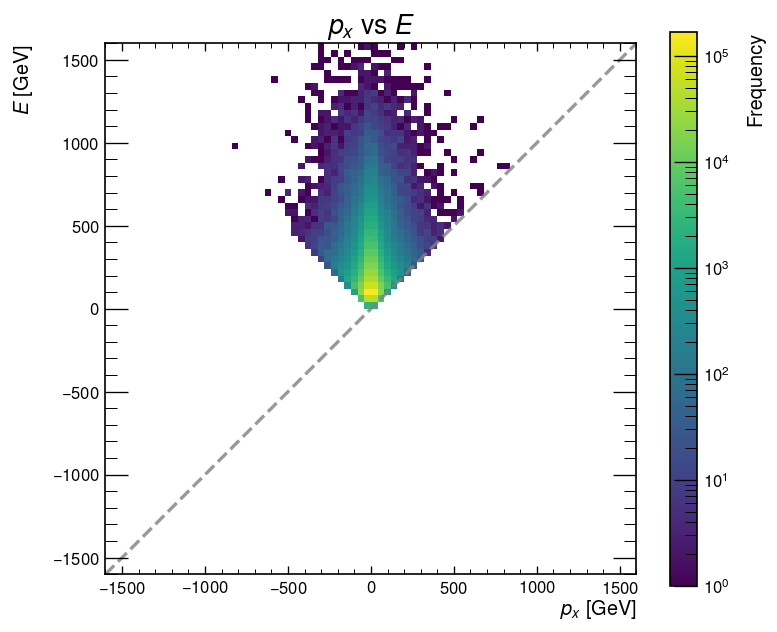

In [9]:
plot.plot_2d_histogram(
    int_kin_df["w_lead_px"],
    int_kin_df["w_lead_py"],
    r"$p_{x}$ vs $p_{y}$ ",
    range=[-500, 500],
    xlabel=r"$p_{x}$ [GeV]",
    ylabel=r"$p_{y}$ [GeV]",
)
plot.plot_2d_histogram(
    int_kin_df["w_lead_px"],
    int_kin_df["w_lead_pz"],
    r"$p_{x}$ vs $p_{z}$ ",
    range=[-1000, 1000],
    xlabel=r"$p_{x}$ [GeV]",
    ylabel=r"$p_{z}$ [GeV]",
)
plot.plot_2d_histogram(
    int_kin_df["w_lead_px"],
    int_kin_df["w_lead_e"],
    r"$p_{x}$ vs $E$ ",
    range=[-1600, 1600],
    xlabel=r"$p_{x}$ [GeV]",
    ylabel=r"$E$ [GeV]",
)

In [10]:
# lead_w_m2 = plt.hist([np.square(np.array(w_lead_m).flatten()) / np.mean(w_lead_m), np.square(np.array(w_sublead_m).flatten()) / np.mean(w_lead_m)], bins=81, stacked=True)
# plt.show()
# lead_w_m2 = plt.hist([np.array(w_lead_m).flatten(), np.array(w_sublead_m).flatten()], bins=81, stacked=True)

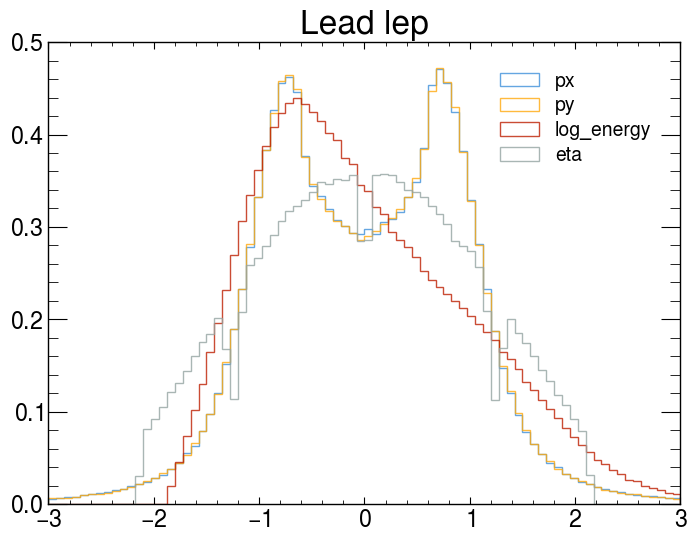

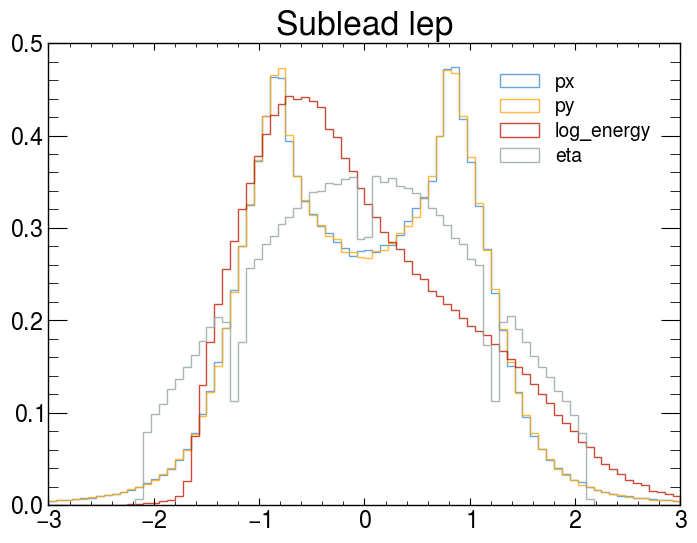

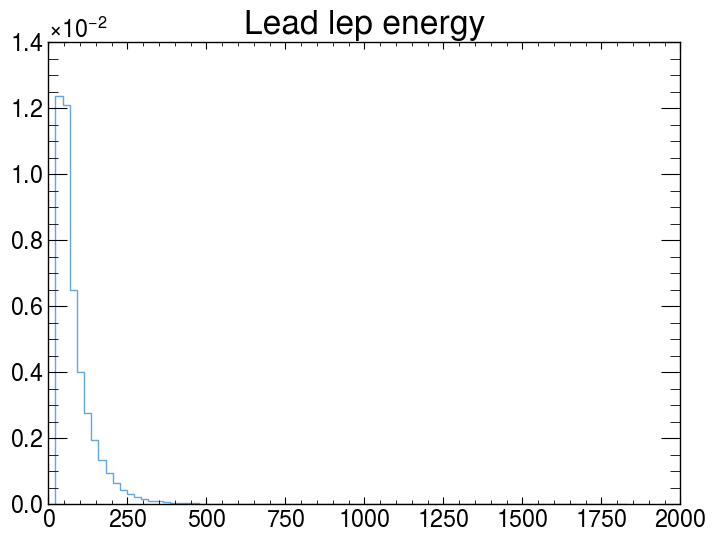

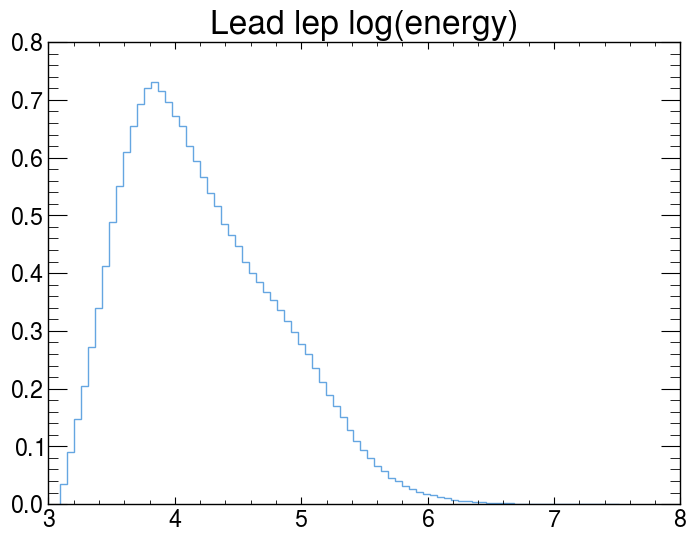

In [11]:
bin_edge = np.linspace(-3, 3, 81)
sublead_px = plt.hist(
    obs_kin[:, 0], bins=bin_edge, alpha=0.8, label="px", histtype="step", density=True
)
lead_py = plt.hist(
    obs_kin[:, 1], bins=bin_edge, alpha=0.8, label="py", histtype="step", density=True
)
lead_log_e = plt.hist(
    obs_kin[:, 2],
    bins=bin_edge,
    alpha=0.8,
    label="log_energy",
    histtype="step",
    density=True,
)
# lead_px = plt.hist(w_lead_px, bins=bin_edge, alpha=.8)
lead_pz = plt.hist(
    obs_kin[:, 3], bins=bin_edge, alpha=0.8, label="eta", histtype="step", density=True
)
# lead_px = plt.hist(w_lead_m, bins=bin_edge, alpha=.8)
# plt.yscale("log")
plt.title("Lead lep")
plt.legend()
plt.show()

sublead_px = plt.hist(
    obs_kin[:, 4], bins=bin_edge, alpha=0.8, label="px", histtype="step", density=True
)
sublead_py = plt.hist(
    obs_kin[:, 5], bins=bin_edge, alpha=0.8, label="py", histtype="step", density=True
)
sublead_log_e = plt.hist(
    obs_kin[:, 6],
    bins=bin_edge,
    alpha=0.8,
    label="log_energy",
    histtype="step",
    density=True,
)
sublead_pz = plt.hist(
    obs_kin[:, 7], bins=bin_edge, alpha=0.8, label="eta", histtype="step", density=True
)
# sublead_px = plt.hist(w_sublead_px, bins=bin_edge, alpha=.8)
# sublead_px = plt.hist(w_sublead_m, bins=bin_edge, alpha=.8)
# plt.yscale("log")
plt.title("Sublead lep")
plt.legend()
plt.show()


lead_energy = plt.hist(
    lead_lep.energy, bins=80, alpha=0.8, label="eta", histtype="step", density=True
)
plt.title("Lead lep energy")
plt.show()
lead_log_energy = plt.hist(
    np.log(lead_lep.energy),
    bins=80,
    alpha=0.8,
    label="eta",
    histtype="step",
    density=True,
)
plt.title("Lead lep log(energy)")
plt.show()

In [12]:
# Train test split

indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.8,
    test_size=0.2,
    random_state=SEED,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=SEED
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
# test_x = np.concatenate([test_x, valid_x], axis=0)
train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]
# test_y = np.concatenate([test_y, valid_y], axis=0)

print("Total evts:", len(indices_arr))
print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)

Total evts: 1008897
X (Interest)
Training data shape: (807117, 10);
Validing data shape: (100890, 10);
Testing data shape: (100890, 10).
Y (Observed)
Training data shape: (807117, 8);
Validing data shape: (100890, 8);
Testing data shape: (100890, 8).


In [13]:
# Make a directory
dir_name = HOME_PATH + "/8th_trial/ww_resregressor_result/"
savedmodel_path = dir_name + "saved_model"
name = "ww_resregressor"

In [14]:
# predict
model = tf.keras.models.load_model(dir_name + name + ".keras")
pred_y = model.predict(test_x)
# save predicted results
np.savez_compressed(dir_name + name + "_data.npz", pred_y=pred_y, test_y=test_y)
sig_pred = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth = np.load(dir_name + name + "_data.npz")["test_y"]

2024-12-05 07:16:29.419361: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1566] failed to allocate 15.99GiB (17171480576 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


   1/3153 ━━━━━━━━━━━━━━━━━━━━ 19:13 366ms/step

I0000 00:00:1733382990.268516 1216243 service.cc:145] XLA service 0x70ba08007db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733382990.268545 1216243 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2024-12-05 07:16:30.279193: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-05 07:16:30.331801: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1733382990.449578 1216243 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3153/3153 ━━━━━━━━━━━━━━━━━━━━ 2s 665us/step


In [15]:
# save predicted results
np.savez_compressed(
    dir_name + name + "_data.npz",
    pred_y=sig_pred.reshape(sig_truth.shape),
    test_y=sig_truth,
)
sig_pred_inv = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth_inv = np.load(dir_name + name + "_data.npz")["test_y"]

In [16]:
bins_range = [(-250, 250), (-250, 250), (-500, 500), (0, 800)]

test, _ = np.histogramdd(
    sig_pred_inv[:, 0:4], bins=[80] * 4, range=bins_range, density=None, weights=None
)
test[1, 2].shape

(80, 80)

In [17]:
from matplotlib.colors import TwoSlopeNorm


def jointProb(name=[0, 1], bins_range=[(-250, 250), (-250, 250)]):
    # Define the number of dimensions
    w0_pred = sig_pred_inv[:, name]  # Adjusted to match n_dims
    w0_truth = sig_truth_inv[:, name]  # Adjusted to match n_dims
    n_dims = len(name)

    bins_num = [80] * n_dims

    # Compute the n-dim joint prob
    truth_hist, edges = np.histogramdd(
        w0_truth, bins=bins_num, range=bins_range, density=None, weights=None
    )
    pred_hist, _ = np.histogramdd(
        w0_pred, bins=bins_num, range=bins_range, density=None, weights=None
    )

    # Compute the ratio of prediction to truth --> rc
    rc = np.divide(
        truth_hist, pred_hist, out=np.zeros_like(truth_hist), where=pred_hist != 0
    )

    # reweighted histograms for each dim
    for dim in range(n_dims):
        plt.figure(figsize=(10, 6))
        plt.hist(
            edges[dim][:-1],
            bins=edges[dim],
            weights=truth_hist.sum(axis=tuple(i for i in range(n_dims) if i != dim)),
            histtype="step",
            label="Truth",
            color="blue",
            density=True,
        )
        plt.hist(
            edges[dim][:-1],
            bins=edges[dim],
            weights=pred_hist.sum(axis=tuple(i for i in range(n_dims) if i != dim)),
            histtype="step",
            label="Pred",
            color="red",
            density=True,
        )
        plt.hist(
            edges[dim][:-1],
            bins=edges[dim],
            weights=(pred_hist * rc).sum(
                axis=tuple(i for i in range(n_dims) if i != dim)
            ),
            histtype="bar",
            label="Reweighted Pred",
            color="tab:red",
            alpha=0.3,
            density=True,
        )
        plt.xlabel(f"$p_{name[dim]}$ [GeV]")
        plt.ylabel("Counts")
        plt.title(f"Reweighted Histogram of $p_{name[dim]}$")
        plt.legend()
        plt.show()

    # 2D histograms for each pair of dimensions
    for i in range(n_dims):
        for j in range(i + 1, n_dims):
            plt.figure(figsize=(10, 6))
            rc_2d = rc.sum(axis=tuple(k for k in range(n_dims) if k != i and k != j))
            cmap = plt.cm.viridis
            cmap.set_under("white")

            plt.hist2d(
                x=np.repeat(edges[i][:-1], bins_num[j]),
                y=np.tile(edges[j][:-1], bins_num[i]),
                bins=[bins_num[i], bins_num[j]],
                weights=rc_2d.flatten(),
                range=[bins_range[i], bins_range[j]],
                cmap=cmap,
                norm=TwoSlopeNorm(vmin=0.001, vcenter=2, vmax=10),
            )
            plt.colorbar(label=f"$R_{{{name[i]},{name[j]}}}(c)$")
            plt.xlabel(f"$p_{name[i]}$ [GeV]")
            plt.ylabel(f"$p_{name[j]}$ [GeV]")
            plt.title(f"$R_{name[i]}(c)$ vs $R_{name[j]}(c)$")
            plt.gca().set_aspect("equal", adjustable="box")  # Ensure equal aspect ratio
            plt.show()

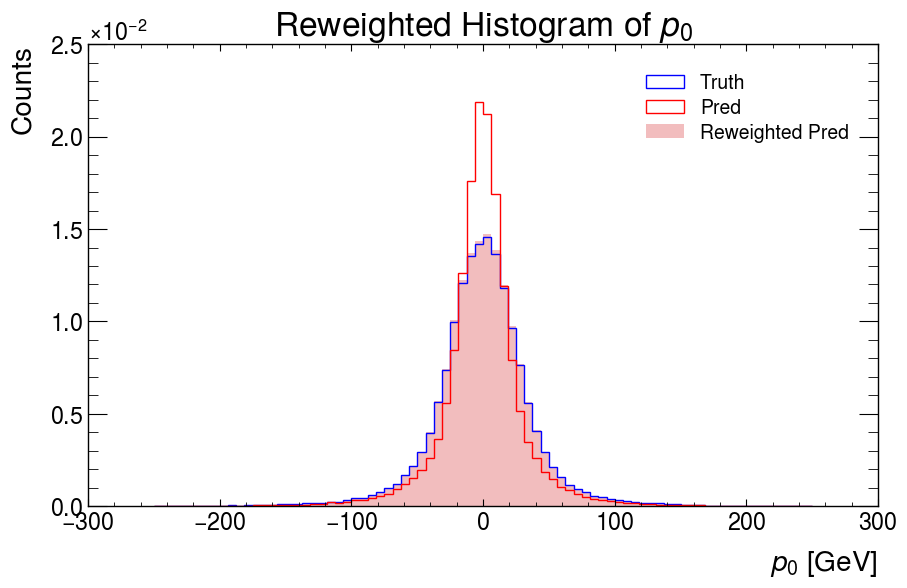

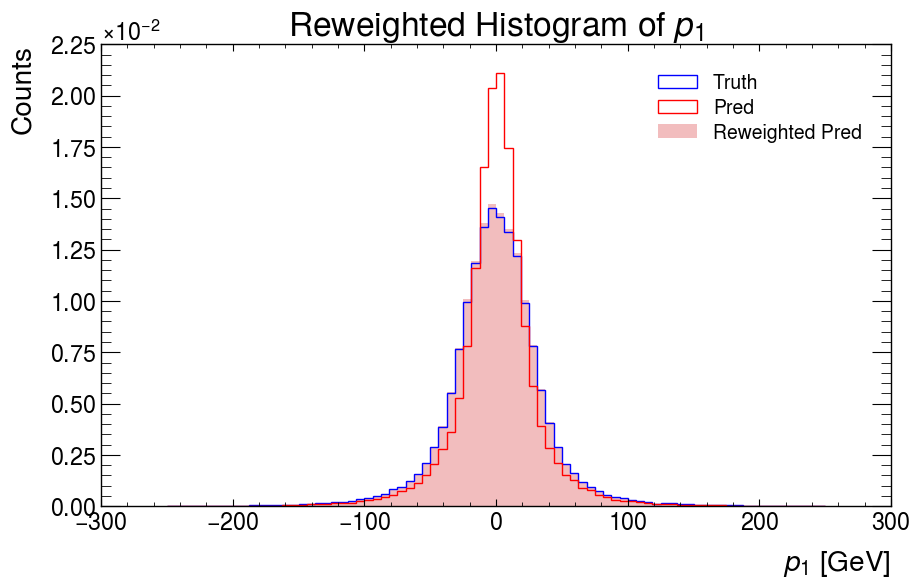

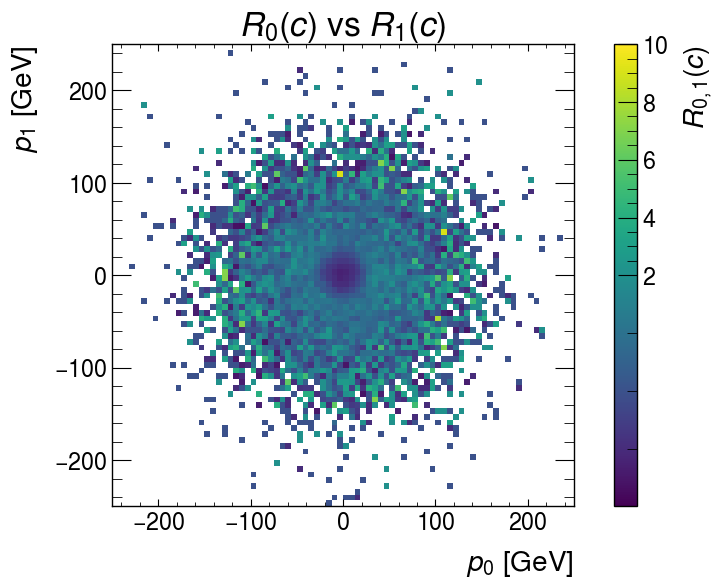

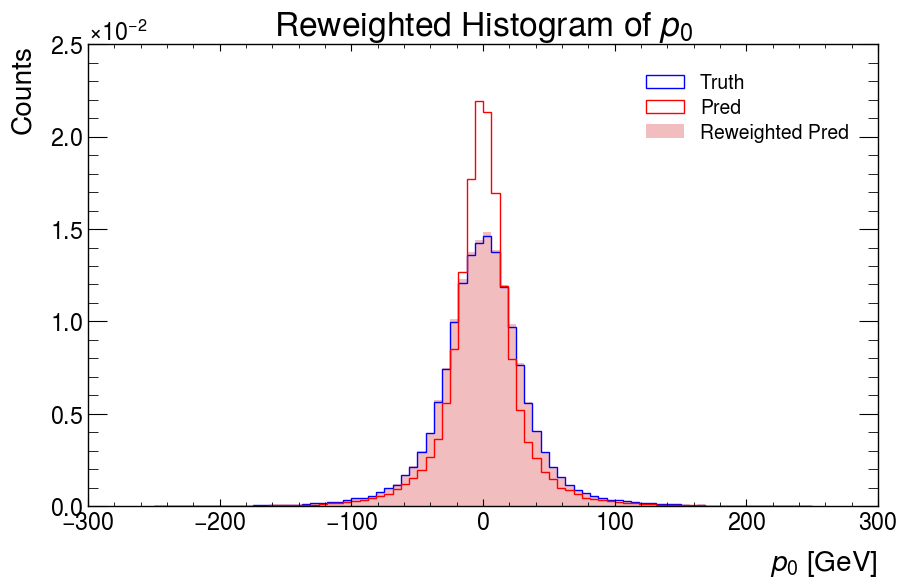

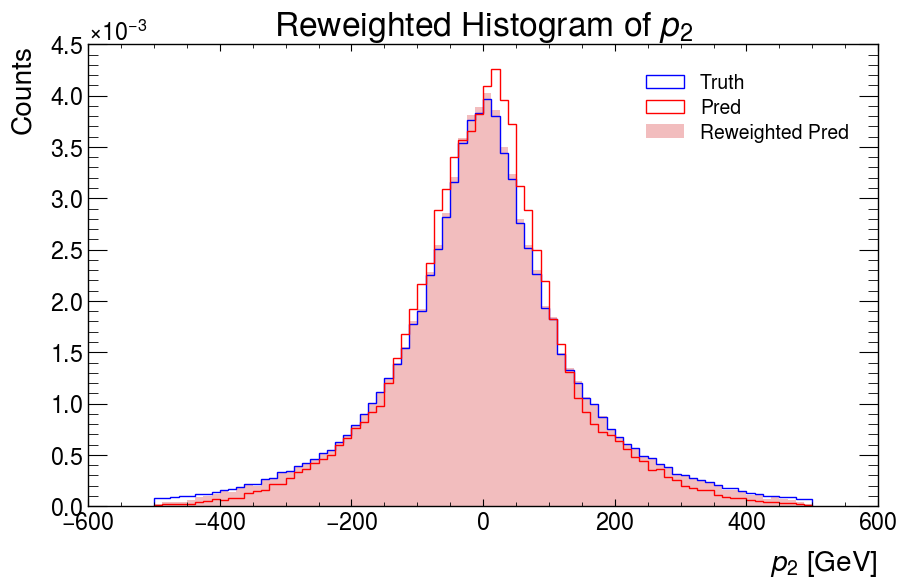

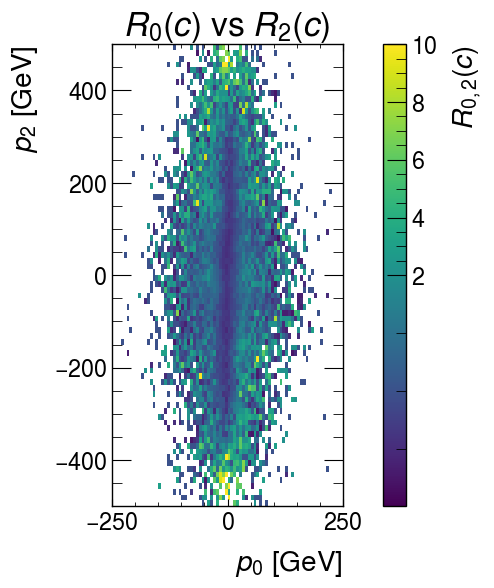

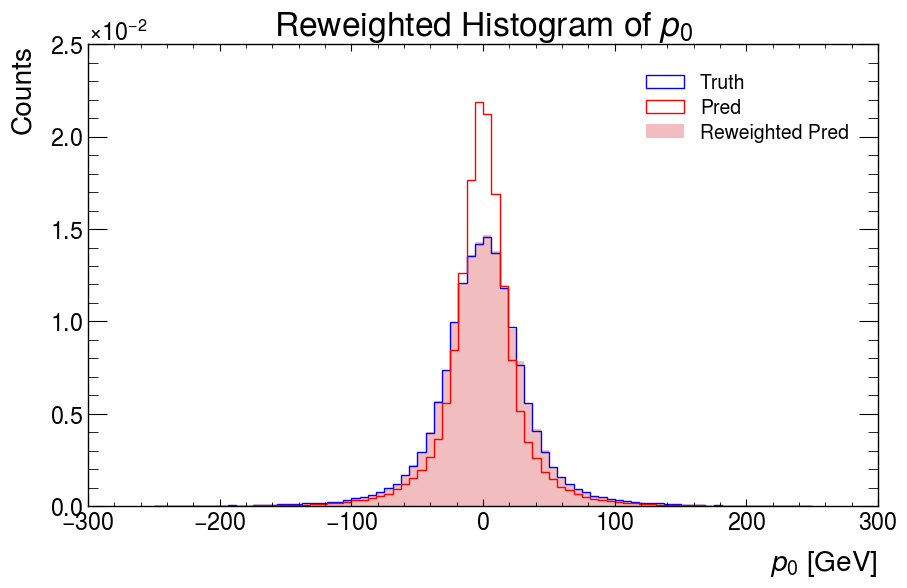

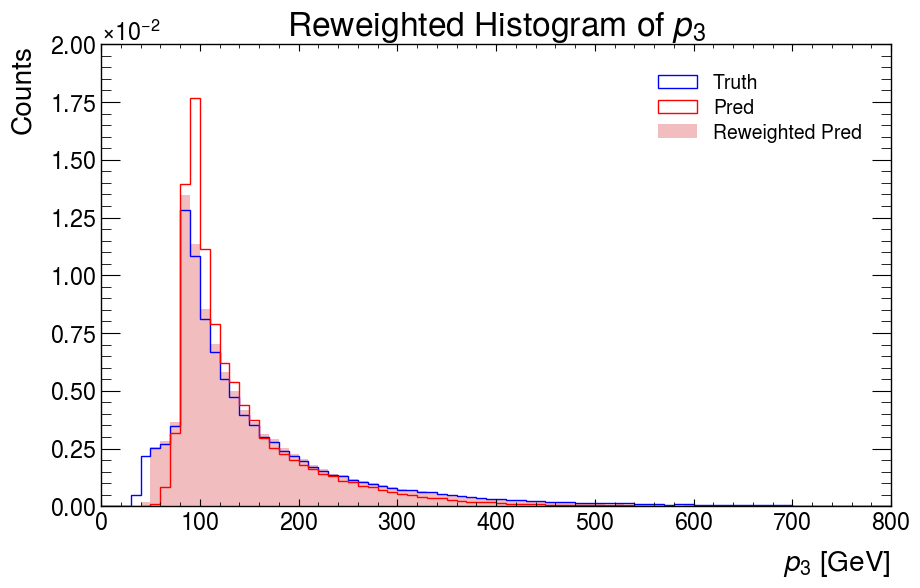

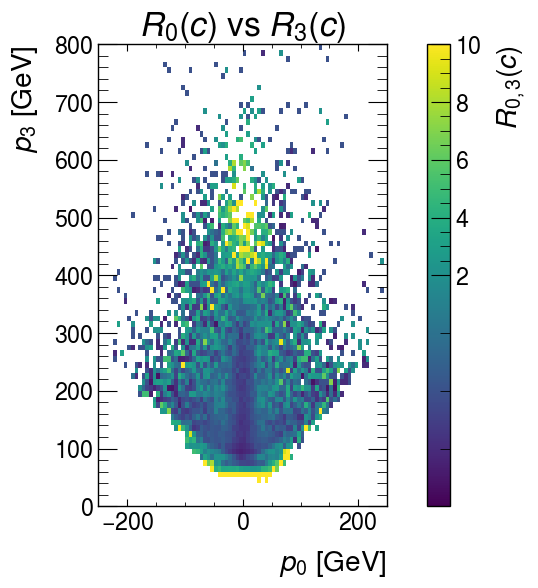

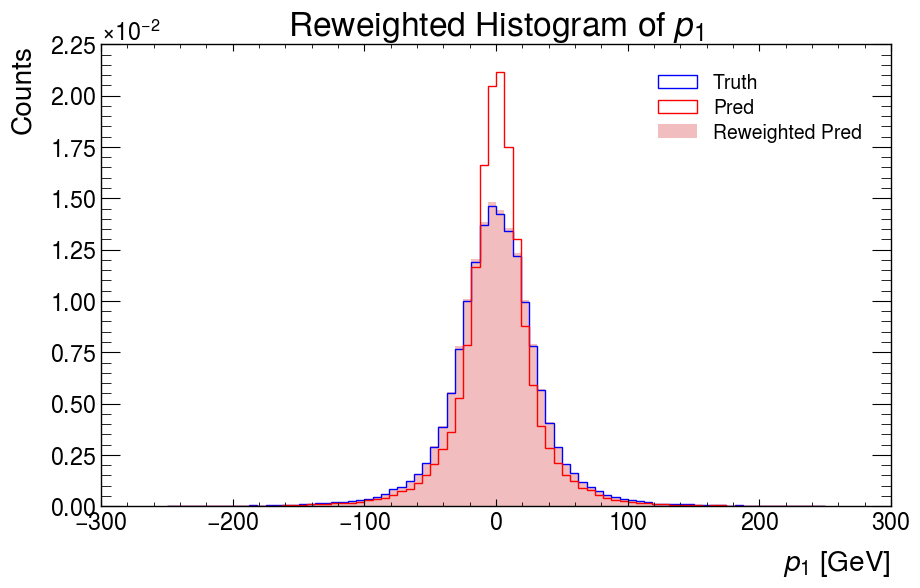

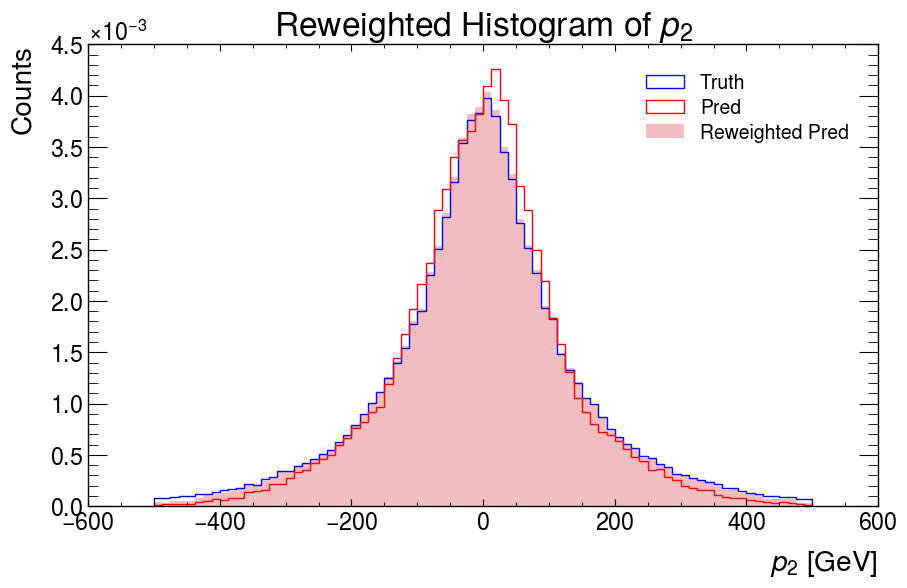

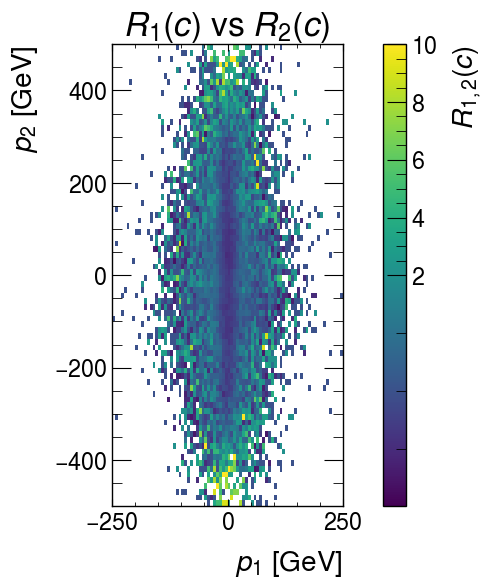

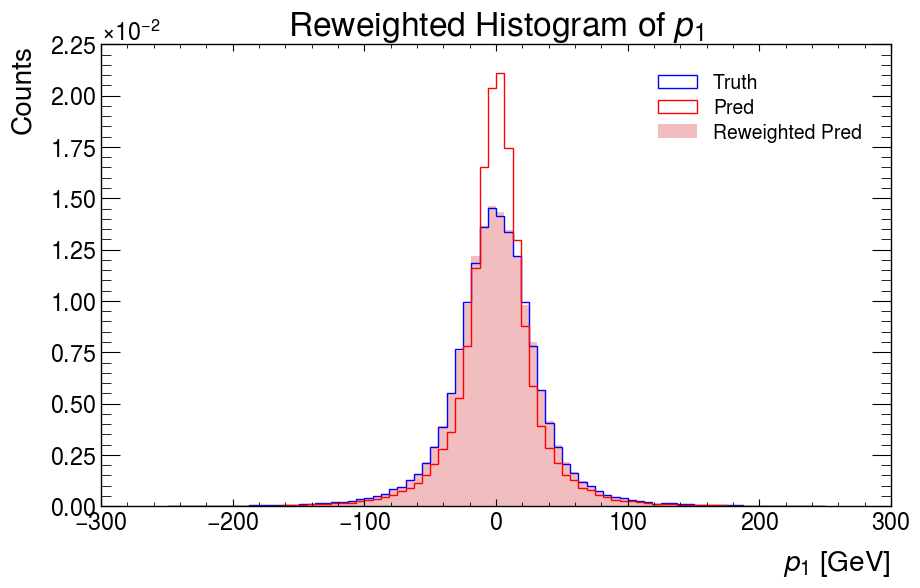

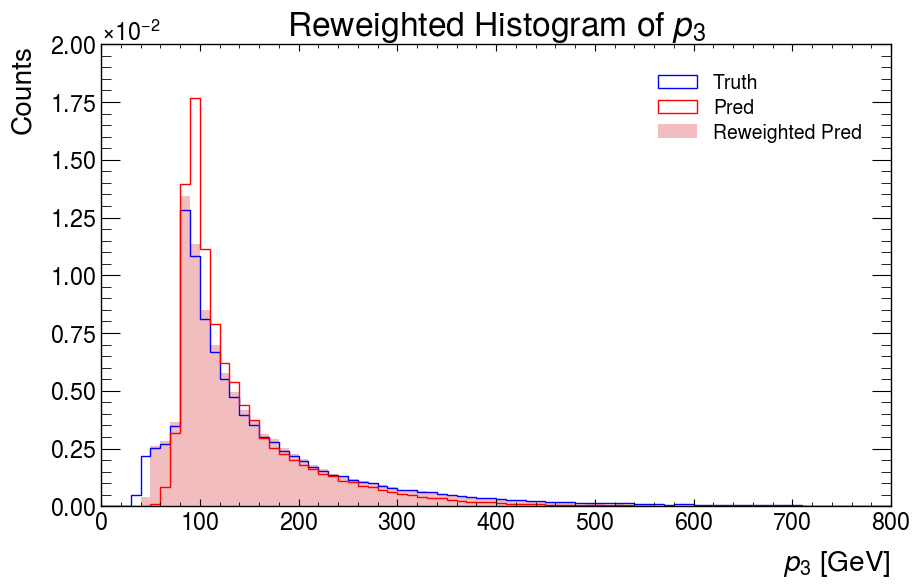

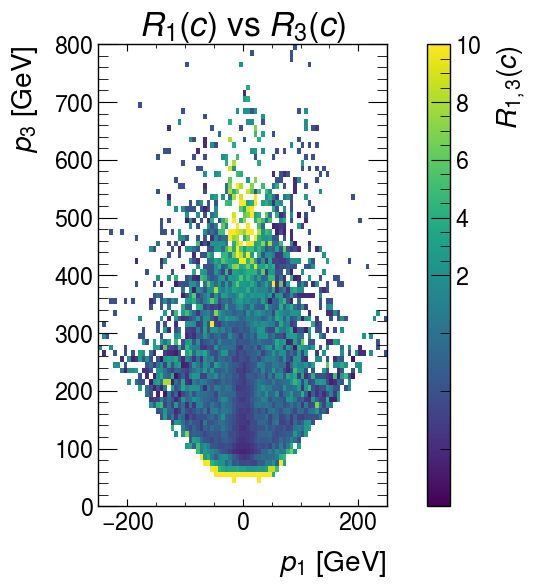

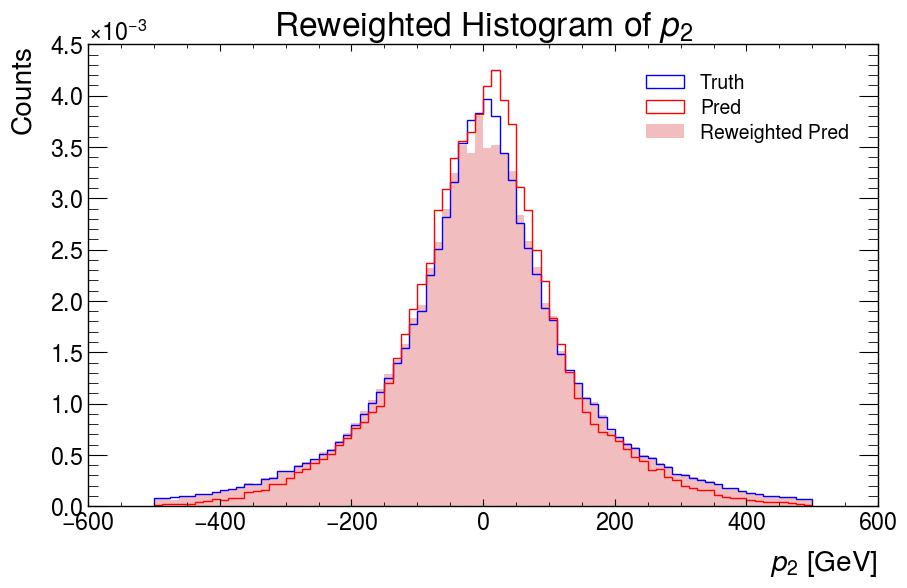

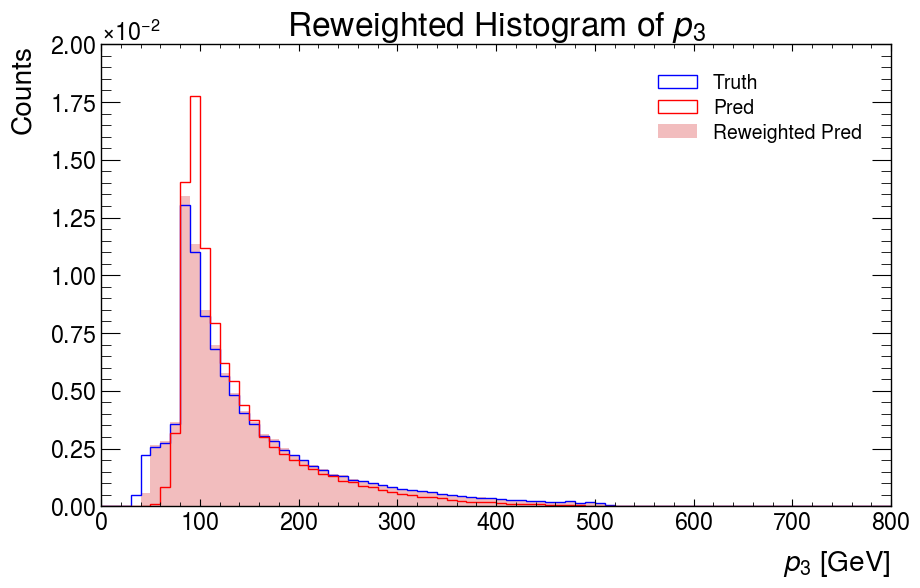

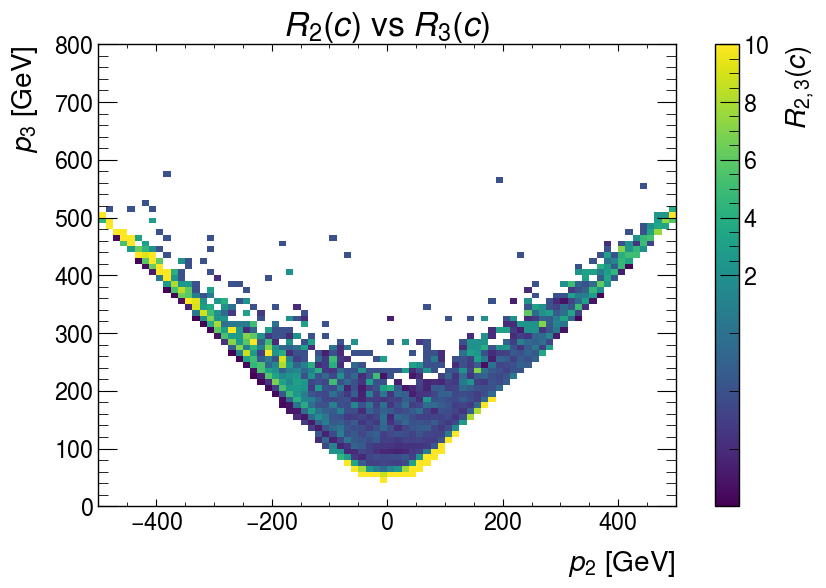

In [18]:
bins_range = [(-250, 250), (-250, 250), (-500, 500), (0, 800)]

jointProb(name=[0, 1], bins_range=[bins_range[0], bins_range[1]])
jointProb(name=[0, 2], bins_range=[bins_range[0], bins_range[2]])
jointProb(name=[0, 3], bins_range=[bins_range[0], bins_range[3]])
jointProb(name=[1, 2], bins_range=[bins_range[1], bins_range[2]])
jointProb(name=[1, 3], bins_range=[bins_range[1], bins_range[3]])
jointProb(name=[2, 3], bins_range=[bins_range[2], bins_range[3]])

-1633.131 2902.102783203125


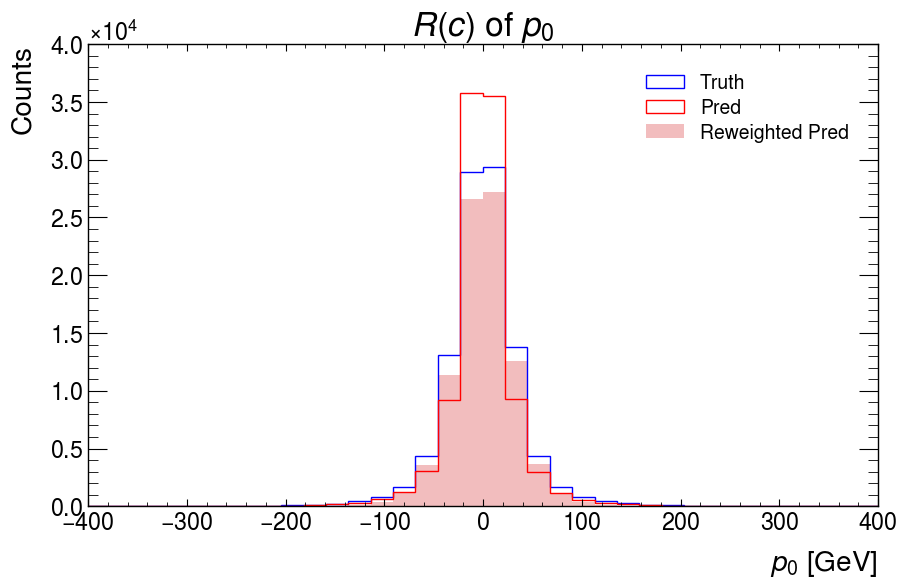

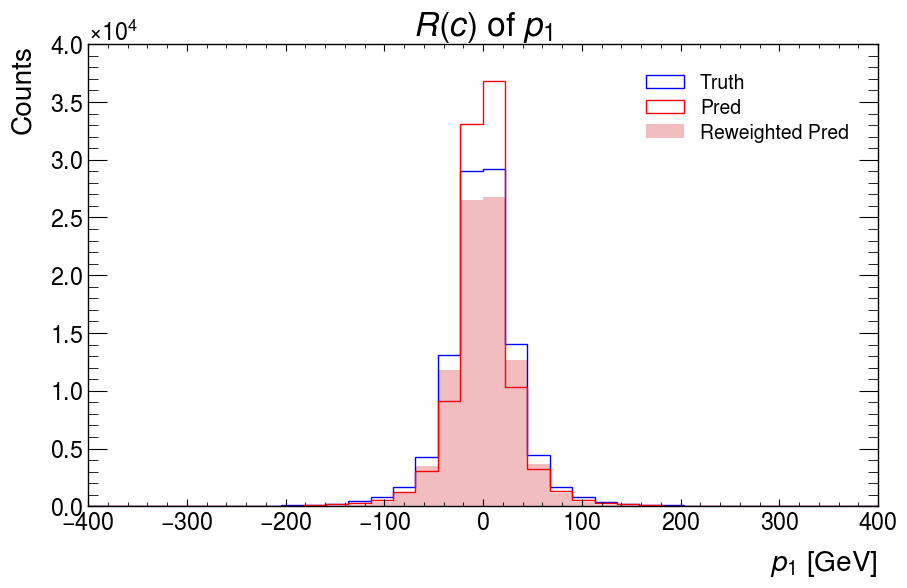

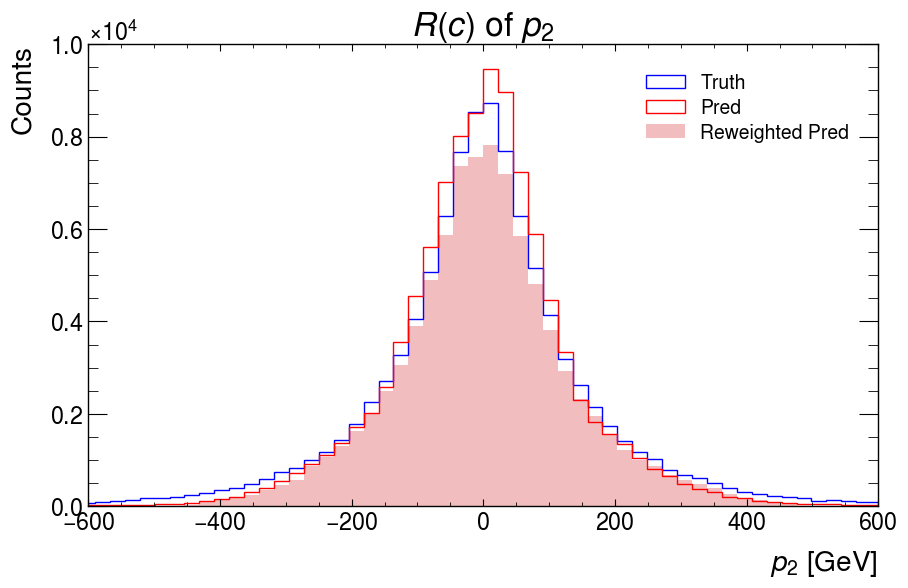

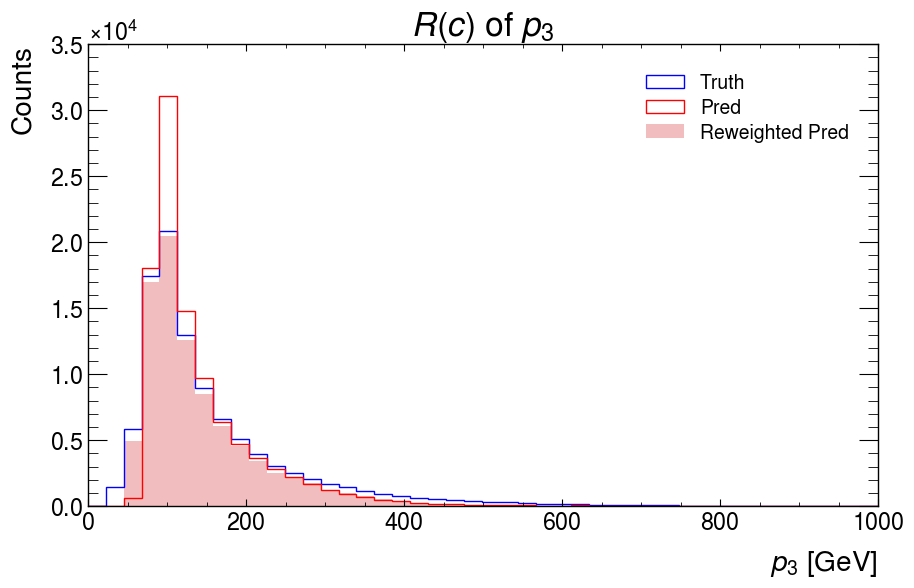

In [19]:
# Parameters
bins = [200]
min_data = np.min([sig_pred_inv[:, 0:4].min(), sig_truth_inv[:, 0:4].min()])
max_data = np.max([sig_pred_inv[:, 0:4].max(), sig_truth_inv[:, 0:4].max()])
ranges = [(min_data, max_data)]
print(min_data, max_data)

# Compute the ratio of prediction to truth --> rc
w0_pred_temp = sig_pred_inv[:, 0:4]
w0_truth_temp = sig_truth_inv[:, 0:4]
n_dim_temp = w0_pred_temp.shape[-1]
bins_range_temp = ranges * n_dim_temp
bins_num_temp = bins * n_dim_temp

truth_hist_temp, edges_temp = np.histogramdd(
    w0_truth_temp, bins=bins_num_temp, range=bins_range_temp, density=False
)
pred_hist_temp, _ = np.histogramdd(
    w0_pred_temp, bins=bins_num_temp, range=bins_range_temp, density=False
)

rc = np.divide(
    truth_hist_temp,
    pred_hist_temp,
    out=np.zeros_like(truth_hist_temp),
    where=pred_hist_temp != 0,
)

# Digitize the data --> retrivr corresponding position in the 4-d histogram
digitized_pred = np.zeros_like(w0_pred_temp, dtype=int)
for dim in range(n_dim_temp):
    digitized_pred[:, dim] = np.digitize(w0_pred_temp[:, dim], edges_temp[dim]) - 1
    digitized_pred[:, dim] = np.clip(digitized_pred[:, dim], 0, bins_num_temp[dim] - 1)

# Extract the reweighting coefficients for each data point
reweighting_coefficients = np.array(
    [rc[tuple(digitized_pred[i])] for i in range(w0_pred_temp.shape[0])]
)

# Calculate the original histograms
n_dims = sig_pred_inv[:, 0:4].shape[1]
bins_num = bins * n_dims
bins_range = ranges * n_dims


def calculate_histograms(data, weights=None):
    return [
        np.histogram(data[:, i], bins=bins[0], range=bins_range[i], weights=weights)[0]
        for i in range(n_dims)
    ]


truth_hist = calculate_histograms(sig_truth_inv[:, 0:4])
pred_hist = calculate_histograms(sig_pred_inv[:, 0:4])
reweighted_hist = calculate_histograms(
    sig_pred_inv[:, 0:4], weights=reweighting_coefficients
)

edges = [
    np.histogram(sig_truth_inv[:, i], bins=bins[0], range=bins_range[i])[1]
    for i in range(n_dims)
]

# Plot the histograms
plot_bins_range = [(-400, 400), (-400, 400), (-600, 600), (0, 1000)]
for dim in range(n_dims):
    plt.figure(figsize=(10, 6))
    plt.hist(
        edges[dim][:-1],
        bins=edges[dim],
        weights=truth_hist[dim],
        histtype="step",
        label="Truth",
        color="blue",
        density=False,
    )
    plt.hist(
        edges[dim][:-1],
        bins=edges[dim],
        weights=pred_hist[dim],
        histtype="step",
        label="Pred",
        color="red",
        density=False,
    )
    plt.hist(
        edges[dim][:-1],
        bins=edges[dim],
        weights=reweighted_hist[dim],
        histtype="bar",
        label="Reweighted Pred",
        color="tab:red",
        alpha=0.3,
        density=False,
    )
    plt.xlim(plot_bins_range[dim])
    plt.xlabel(f"$p_{dim}$ [GeV]")
    plt.ylabel("Counts")
    plt.title(f"$R(c)$ of $p_{dim}$")
    plt.legend()
    plt.show()

In [20]:
# Compute the ratio of prediction to truth --> rc
bins_range = [(-250, 250), (-250, 250), (-500, 500), (0, 800)]
bins_num = [80] * len(bins_range)
truth_hist, edges = np.histogramdd(
    sig_truth_inv[:, 0:4], bins=bins_num, range=bins_range, density=None, weights=None
)
pred_hist, _ = np.histogramdd(
    sig_truth_inv[:, 0:4], bins=bins_num, range=bins_range, density=None, weights=None
)
rc_tot = np.divide(
    truth_hist, pred_hist, out=np.zeros_like(truth_hist), where=pred_hist != 0
)

In [21]:
# Compute the ratio of prediction to truth --> rc
bins_range = [(-250, 250), (-250, 250)]
bins_num = [80] * len(bins_range)
truth_hist, edges = np.histogramdd(
    sig_truth_inv[:, 0:2], bins=bins_num, range=bins_range, density=None, weights=None
)
pred_hist, _ = np.histogramdd(
    sig_truth_inv[:, 0:2], bins=bins_num, range=bins_range, density=None, weights=None
)
rc_test = np.divide(
    truth_hist, pred_hist, out=np.zeros_like(truth_hist), where=pred_hist != 0
)

Max and min of 0th variable: 7483.000, 3.000


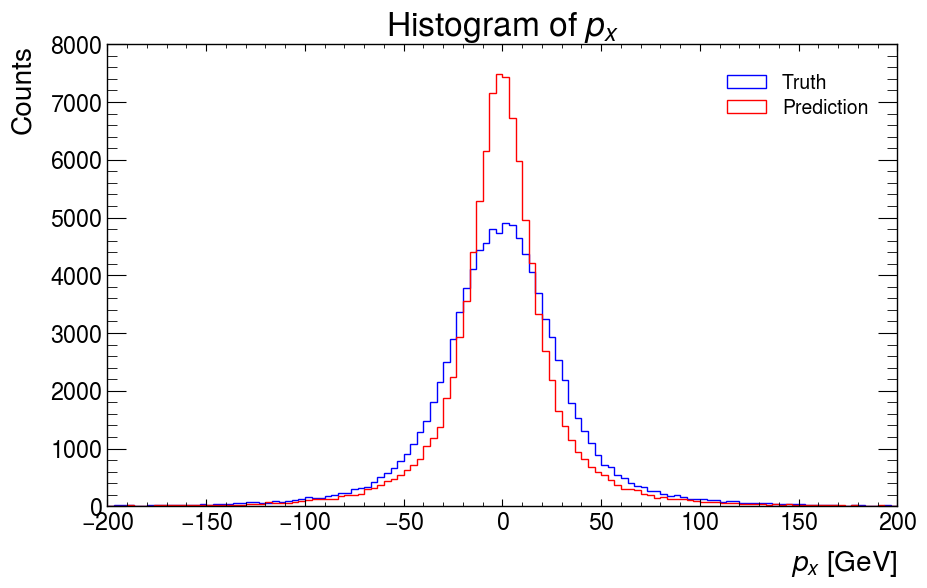

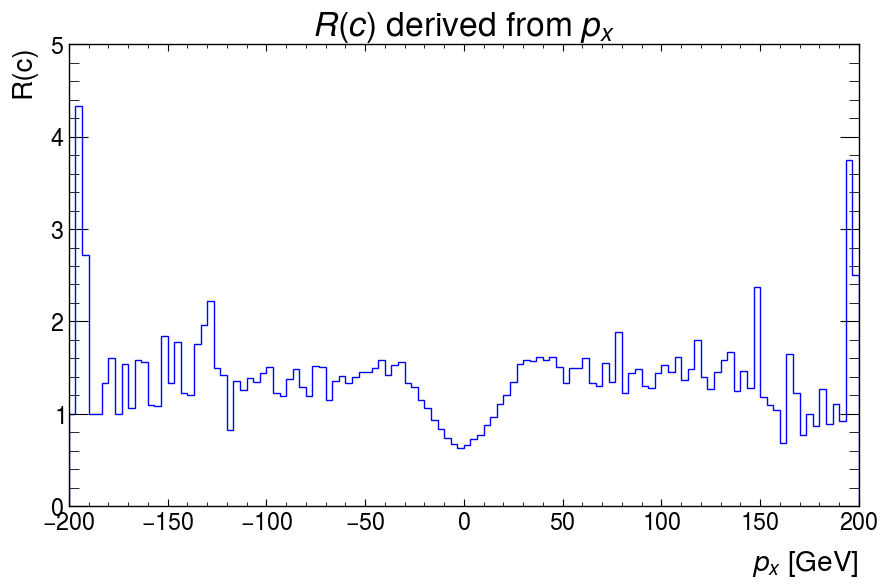

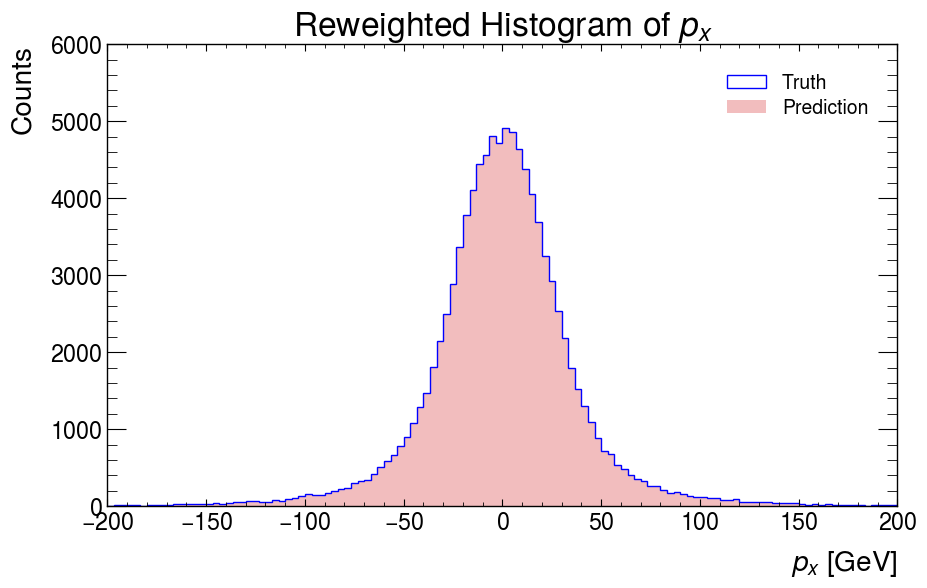

In [22]:
# single reweighting
# check onlt px

bins_range = (-200, 200)
bins_num = 120
tor = 1e-10
prod = np.ones(bins_num)

truth_hist, truth_bins_edge = np.histogram(
    sig_truth_inv[:, 0], bins=bins_num, range=bins_range, weights=None
)
pred_hist, pred_bins_edge = np.histogram(
    sig_pred_inv[:, 0], bins=bins_num, range=bins_range, weights=None
)
print(
    f"Max and min of {0}th variable: {np.max(pred_hist):.3f}, {np.min(pred_hist):.3f}"
)

# Plot the histograms to check numpy hist
plt.figure(figsize=(10, 6))
plt.hist(
    truth_bins_edge[:-1],
    bins=truth_bins_edge,
    weights=truth_hist,
    histtype="step",
    label="Truth",
    color="blue",
)
plt.hist(
    pred_bins_edge[:-1],
    bins=pred_bins_edge,
    weights=pred_hist,
    histtype="step",
    label="Prediction",
    color="red",
)
plt.xlabel(r"$p_{x}$ [GeV]")
plt.ylabel("Counts")
plt.title("Histogram of $p_{x}$")
plt.legend()
plt.show()

# Plot the histograms to check ratio of prediction to truth
# rc = np.divide(truth_hist, pred_hist + tor)
rc = np.divide(
    truth_hist,
    pred_hist,
    out=np.zeros_like(truth_hist, dtype=np.float64),
    where=pred_hist != 0,
)
plt.figure(figsize=(10, 6))
plt.hist(
    truth_bins_edge[:-1],
    bins=truth_bins_edge,
    weights=rc,
    histtype="step",
    color="blue",
)
plt.xlabel(r"$p_x$ [GeV]")
plt.ylabel("R(c)")
plt.title("$R(c)$ derived from $p_{x}$")
plt.show()

# Plot the histograms to check numpy hist
plt.figure(figsize=(10, 6))
plt.hist(
    truth_bins_edge[:-1],
    bins=truth_bins_edge,
    weights=truth_hist,
    histtype="step",
    label="Truth",
    color="blue",
)
plt.hist(
    pred_bins_edge[:-1],
    bins=pred_bins_edge,
    weights=pred_hist * rc,
    histtype="bar",
    label="Prediction",
    color="tab:red",
    alpha=0.3,
)
plt.xlabel(r"$p_{x}$ [GeV]")
plt.ylabel("Counts")
plt.title("Reweighted Histogram of $p_{x}$")
plt.legend()
plt.show()

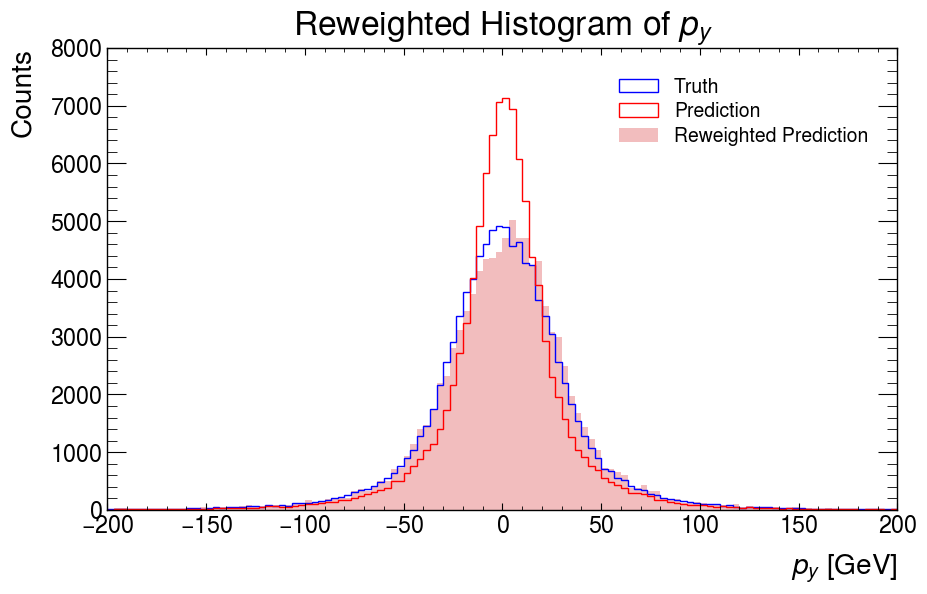

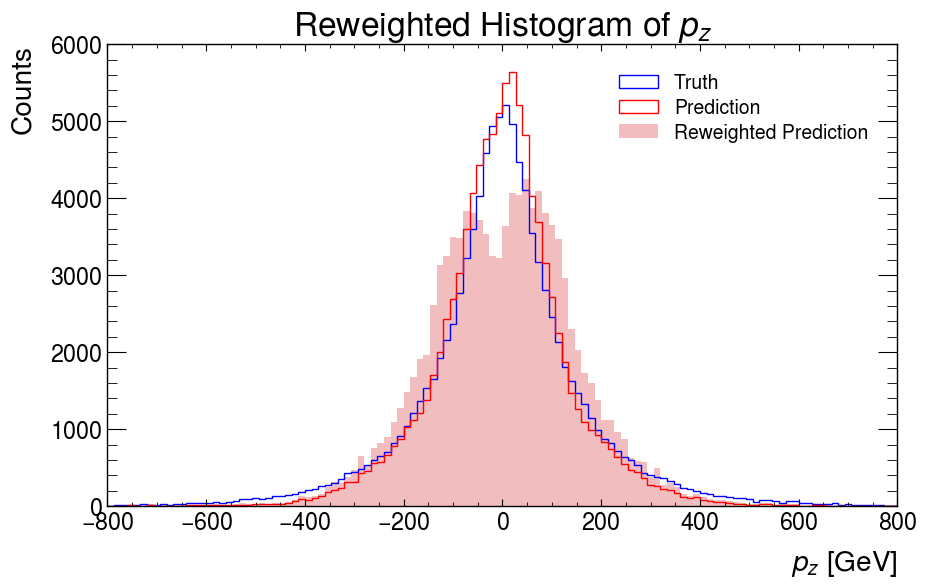

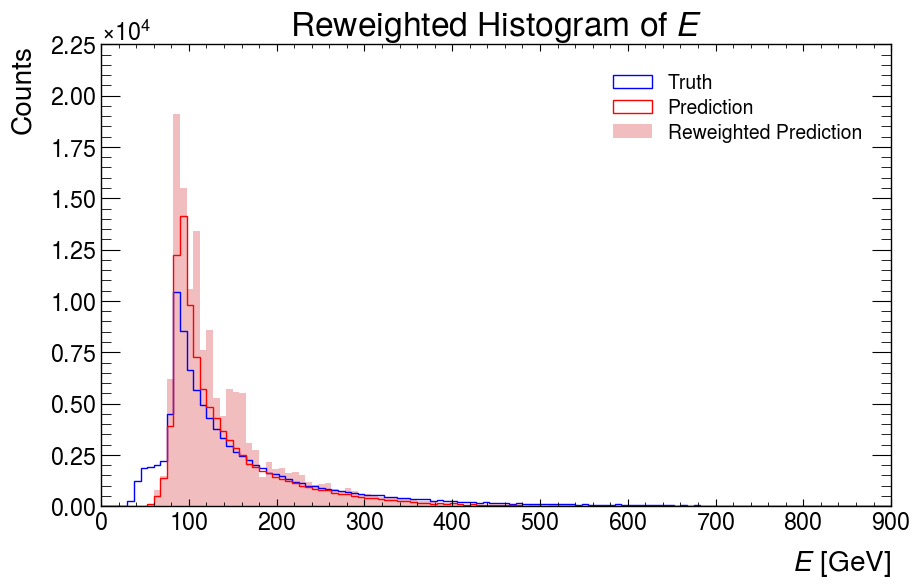

In [23]:
# Plot the histograms to check numpy hist (py)
truth_hist, truth_bins_edge = np.histogram(
    sig_truth_inv[:, 1], bins=bins_num, range=bins_range, weights=None
)
pred_hist, pred_bins_edge = np.histogram(
    sig_pred_inv[:, 1], bins=bins_num, range=bins_range, weights=None
)
plt.figure(figsize=(10, 6))
hist_info = plt.hist(
    truth_bins_edge[:-1],
    bins=truth_bins_edge,
    weights=truth_hist,
    histtype="step",
    label="Truth",
    color="blue",
)
hist_info = plt.hist(
    pred_bins_edge[:-1],
    bins=pred_bins_edge,
    weights=pred_hist,
    histtype="step",
    label="Prediction",
    color="red",
)
hist_info = plt.hist(
    pred_bins_edge[:-1],
    bins=pred_bins_edge,
    weights=pred_hist * rc,
    histtype="bar",
    label="Reweighted Prediction",
    color="tab:red",
    alpha=0.3,
)
plt.xlabel(r"$p_{y}$ [GeV]")
plt.ylabel("Counts")
plt.title("Reweighted Histogram of $p_{y}$")
plt.legend()
plt.show()

# Plot the histograms to check numpy hist (pz)
bins_range = (-800, 800)
truth_hist, truth_bins_edge = np.histogram(
    sig_truth_inv[:, 2], bins=bins_num, range=bins_range, weights=None
)
pred_hist, pred_bins_edge = np.histogram(
    sig_pred_inv[:, 2], bins=bins_num, range=bins_range, weights=None
)
plt.figure(figsize=(10, 6))
hist_info = plt.hist(
    truth_bins_edge[:-1],
    bins=truth_bins_edge,
    weights=truth_hist,
    histtype="step",
    label="Truth",
    color="blue",
)
hist_info = plt.hist(
    pred_bins_edge[:-1],
    bins=pred_bins_edge,
    weights=pred_hist,
    histtype="step",
    label="Prediction",
    color="red",
)
hist_info = plt.hist(
    pred_bins_edge[:-1],
    bins=pred_bins_edge,
    weights=pred_hist * rc,
    histtype="bar",
    label="Reweighted Prediction",
    color="tab:red",
    alpha=0.3,
)
plt.xlabel(r"$p_{z}$ [GeV]")
plt.ylabel("Counts")
plt.title("Reweighted Histogram of $p_{z}$")
plt.legend()
plt.show()

# Plot the histograms to check numpy hist (energy)
bins_range = (0, 900)
truth_hist, truth_bins_edge = np.histogram(
    sig_truth_inv[:, 3], bins=bins_num, range=bins_range, weights=None
)
pred_hist, pred_bins_edge = np.histogram(
    sig_pred_inv[:, 3], bins=bins_num, range=bins_range, weights=None
)
plt.figure(figsize=(10, 6))
hist_info = plt.hist(
    truth_bins_edge[:-1],
    bins=truth_bins_edge,
    weights=truth_hist,
    histtype="step",
    label="Truth",
    color="blue",
)
hist_info = plt.hist(
    pred_bins_edge[:-1],
    bins=pred_bins_edge,
    weights=pred_hist,
    histtype="step",
    label="Prediction",
    color="red",
)
hist_info = plt.hist(
    pred_bins_edge[:-1],
    bins=pred_bins_edge,
    weights=pred_hist * rc,
    histtype="bar",
    label="Reweighted Prediction",
    color="tab:red",
    alpha=0.3,
)
plt.xlabel(r"$E$ [GeV]")
plt.ylabel("Counts")
plt.title("Reweighted Histogram of $E$")
plt.legend()
plt.show()

In [24]:
bins_range = [(-500, 500)] * 4

bins_num = 120
tor = 1e-10

p0_truth_hist, p0_edges = np.histogram(
    sig_truth_inv[:, 0], bins=bins_num, range=bins_range[0], weights=None
)
p0_pred_hist, _ = np.histogram(
    sig_pred_inv[:, 0], bins=bins_num, range=bins_range[0], weights=None
)
p0_rc = np.divide(
    p0_truth_hist,
    p0_pred_hist,
    out=np.zeros_like(p0_truth_hist, dtype=np.float64),
    where=p0_pred_hist != 0,
)

p1_truth_hist, p1_edges = np.histogram(
    sig_truth_inv[:, 1], bins=bins_num, range=bins_range[1], weights=None
)
p1_pred_hist, _ = np.histogram(
    sig_pred_inv[:, 1], bins=bins_num, range=bins_range[1], weights=None
)
p1_rc = np.divide(
    p1_truth_hist,
    p1_pred_hist,
    out=np.zeros_like(p1_truth_hist, dtype=np.float64),
    where=p1_pred_hist != 0,
)

p2_truth_hist, p2_edges = np.histogram(
    sig_truth_inv[:, 2], bins=bins_num, range=bins_range[2], weights=None
)
p2_pred_hist, _ = np.histogram(
    sig_pred_inv[:, 2], bins=bins_num, range=bins_range[2], weights=None
)
p2_rc = np.divide(
    p2_truth_hist,
    p2_pred_hist,
    out=np.zeros_like(p2_truth_hist, dtype=np.float64),
    where=p2_pred_hist != 0,
)

p3_truth_hist, p3_edges = np.histogram(
    sig_truth_inv[:, 3], bins=bins_num, range=bins_range[3], weights=None
)
p3_pred_hist, _ = np.histogram(
    sig_pred_inv[:, 3], bins=bins_num, range=bins_range[3], weights=None
)
p3_rc = np.divide(
    p3_truth_hist,
    p3_pred_hist,
    out=np.zeros_like(p3_truth_hist, dtype=np.float64),
    where=p3_pred_hist != 0,
)

# Combine reweighting coefficients
# rc = p0_rc * p1_rc * p2_rc * p3_rc
rc = np.prod(
    [p0_rc, p1_rc],
    axis=0,
    out=np.zeros_like(p0_rc),
    where=(p0_rc != 0) & (p1_rc != 0),
)
rc = np.prod(
    [p2_rc],
    axis=0,
    out=np.zeros_like(p0_rc),
    where=(p2_rc != 0),
)

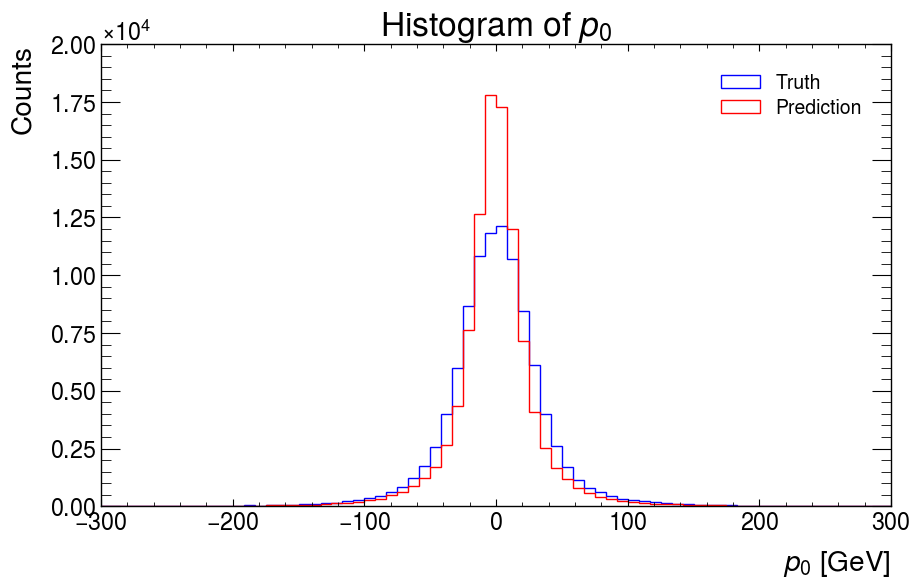

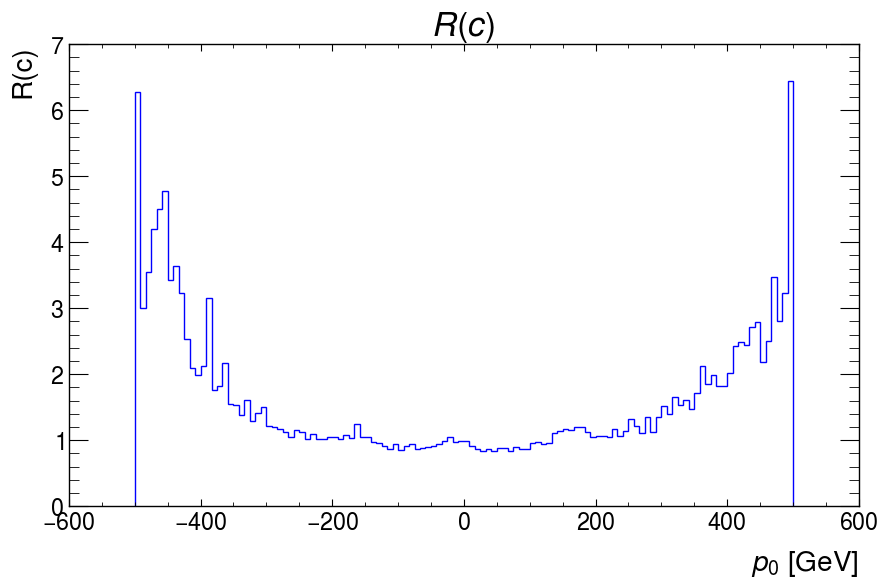

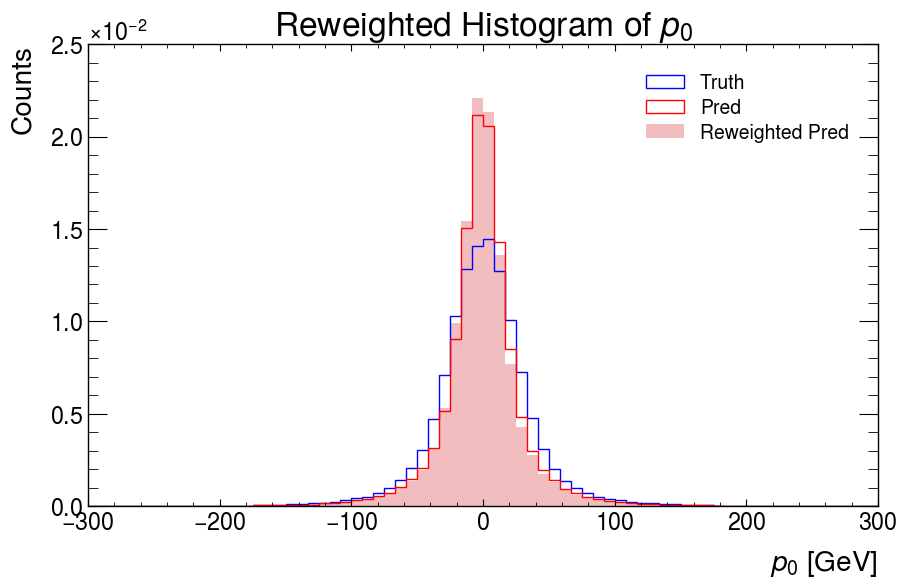

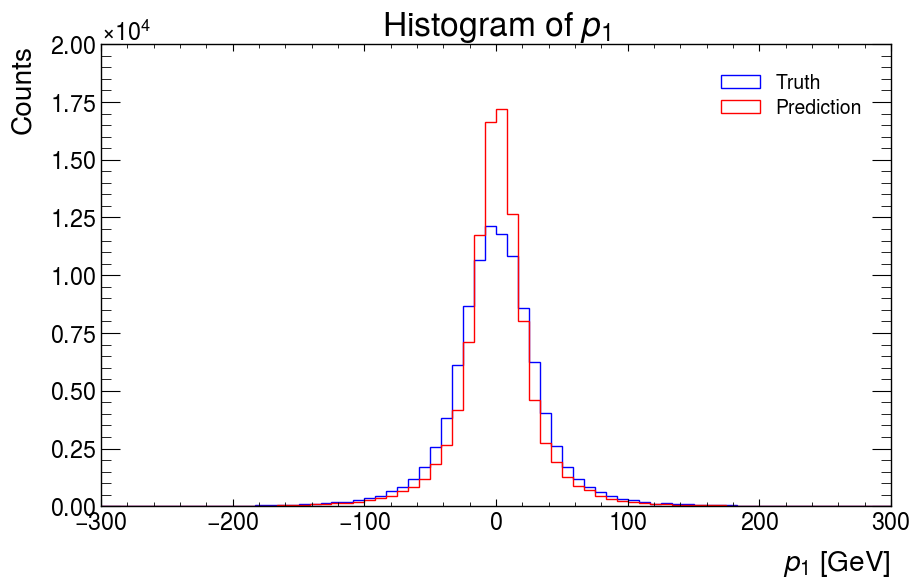

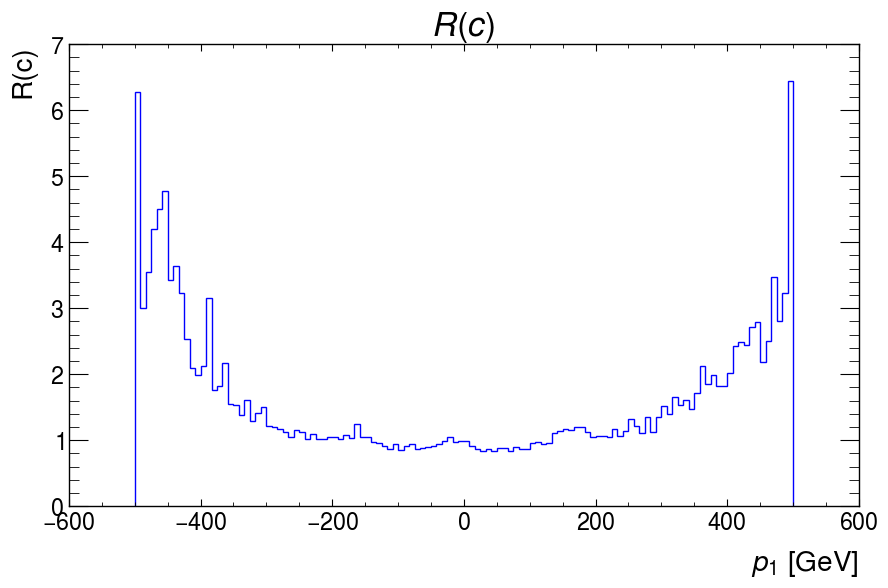

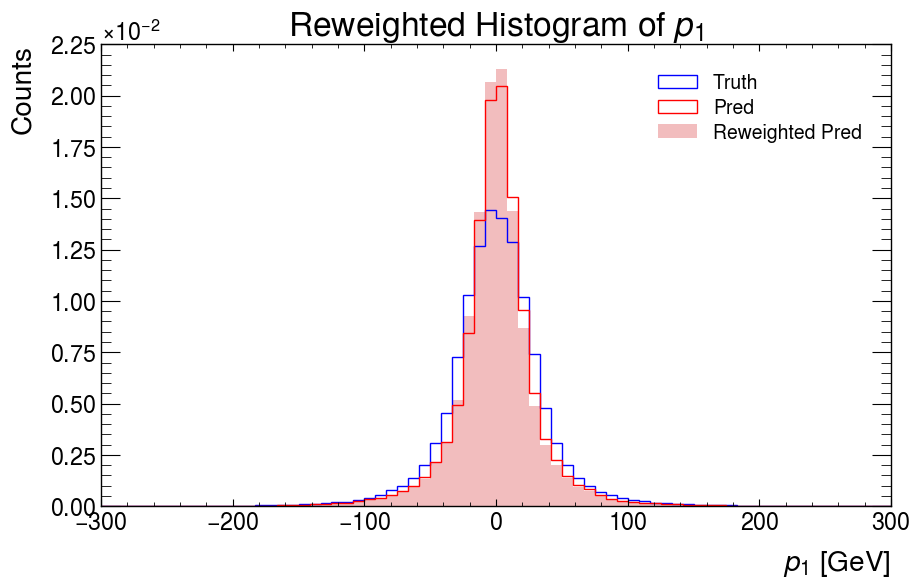

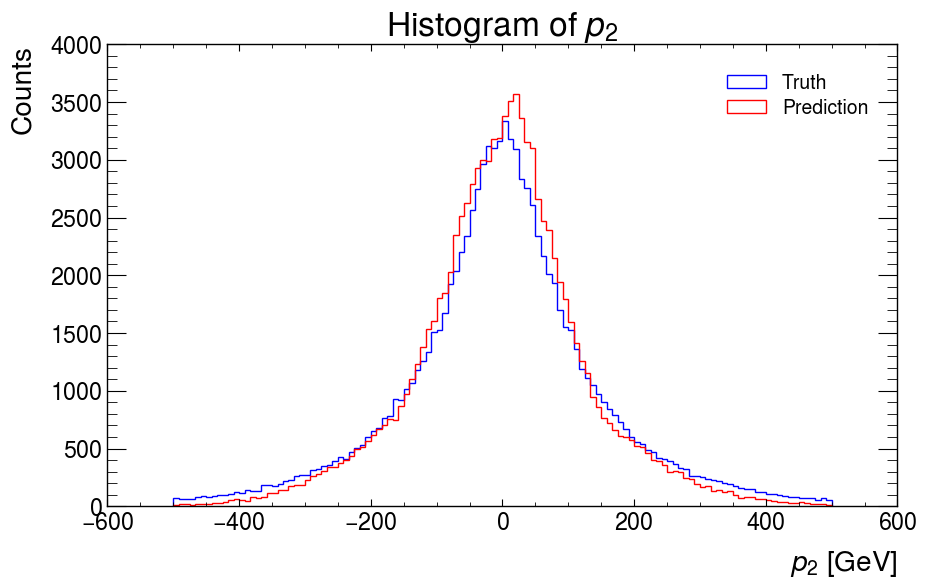

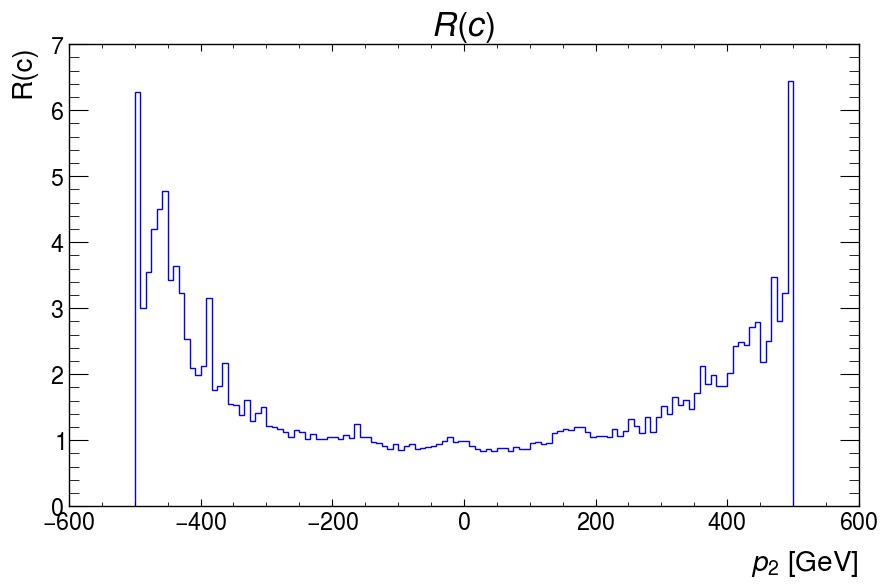

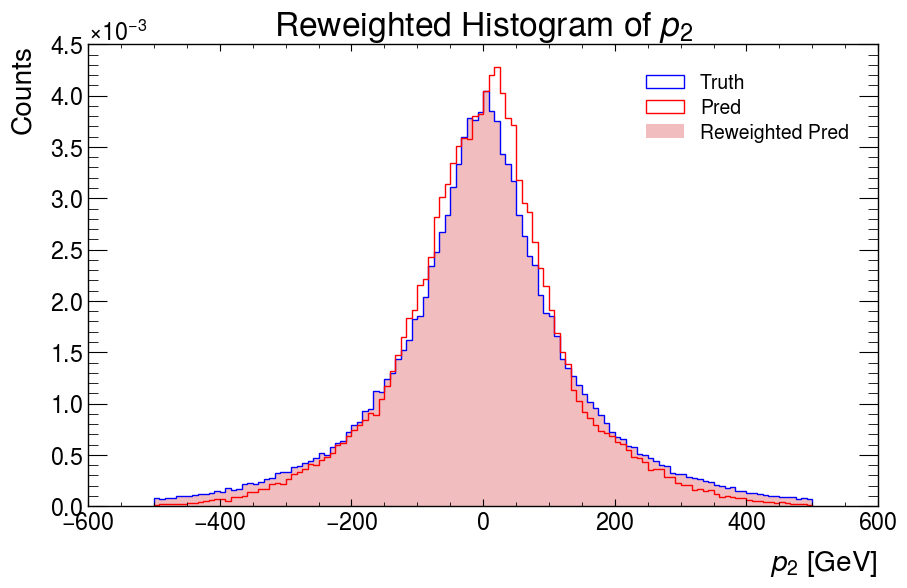

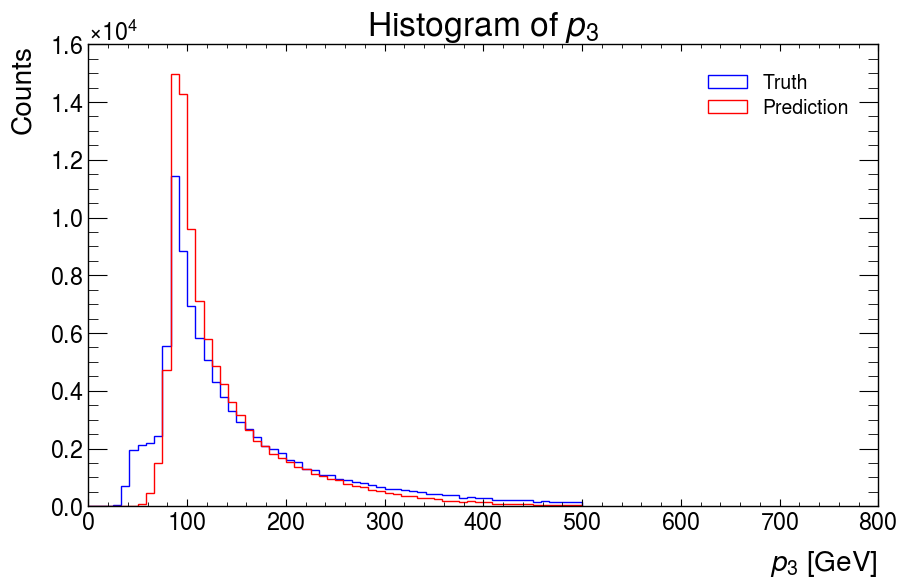

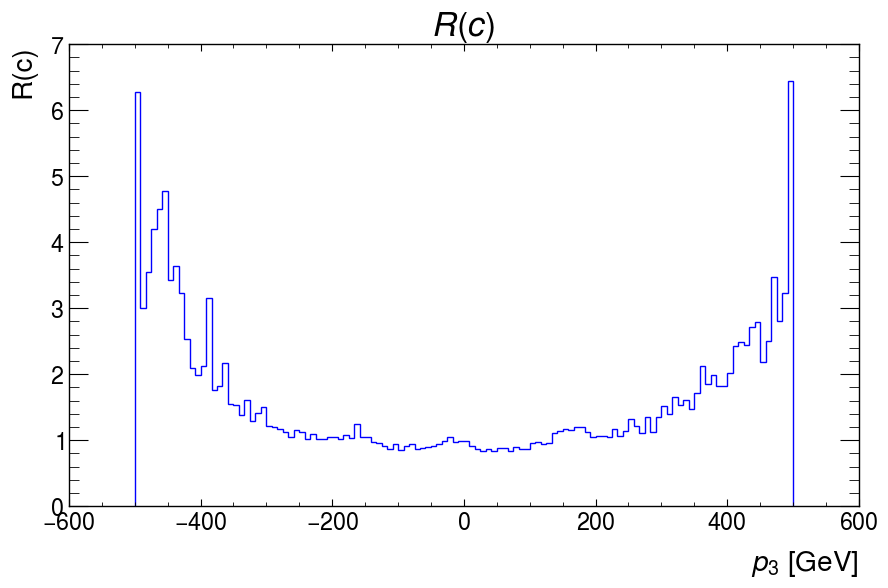

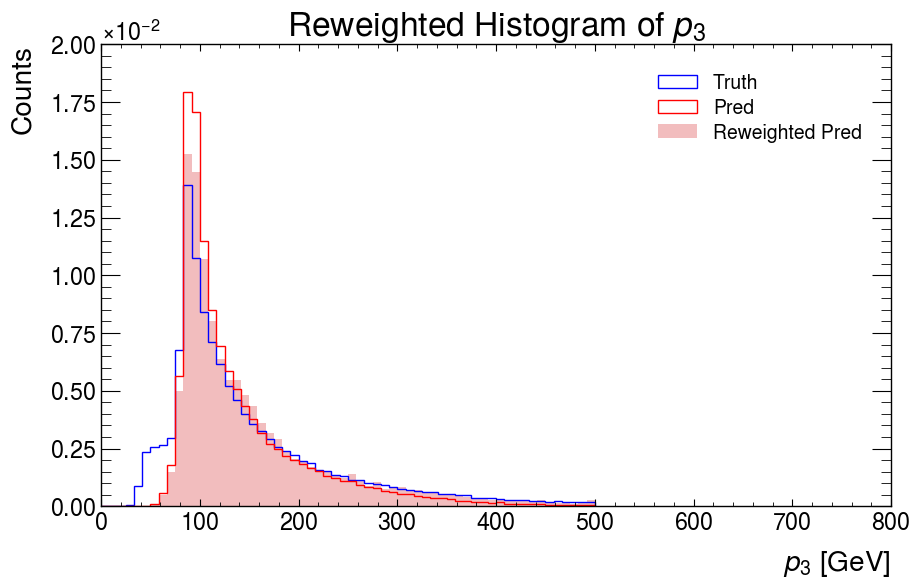

In [25]:
# Plot the histograms to check numpy hist
prod_edges = [p0_edges, p1_edges, p2_edges, p3_edges]
prod_pred_hist = [p0_pred_hist, p1_pred_hist, p2_pred_hist, p3_pred_hist]
prod_truth_hist = [p0_truth_hist, p1_truth_hist, p2_truth_hist, p3_truth_hist]
# prod_rc = [p0_rc, p1_rc, p2_rc, p3_rc] # debug
prod_rc = [rc] * 4
prod_range = [(-300, 300), (-300, 300), (-600, 600), (0, 800)]

for i in range(4):
    plt.figure(figsize=(10, 6))
    plt.hist(
        prod_edges[i][:-1],
        bins=prod_edges[i],
        weights=prod_truth_hist[i],
        histtype="step",
        label="Truth",
        color="blue",
    )
    plt.hist(
        prod_edges[i][:-1],
        bins=prod_edges[i],
        weights=prod_pred_hist[i],
        histtype="step",
        label="Prediction",
        color="red",
    )
    plt.xlim(prod_range[i])
    plt.xlabel(f"$p_{{{i}}}$ [GeV]")
    plt.ylabel("Counts")
    plt.title(f"Histogram of $p_{{{i}}}$")
    plt.legend()
    plt.show()

    # Plot the histograms to check ratio of prediction to truth
    plt.figure(figsize=(10, 6))
    plt.hist(
        prod_edges[i][:-1],
        bins=prod_edges[i],
        weights=prod_rc[i],
        histtype="step",
        color="blue",
    )
    # plt.xlim(prod_range[i])
    plt.xlabel(f"$p_{{{i}}}$ [GeV]")
    plt.ylabel("R(c)")
    plt.title(f"$R(c)$")
    plt.show()

    # Plot the histograms to check numpy hist
    plt.figure(figsize=(10, 6))
    plt.hist(
        prod_edges[i][:-1],
        bins=prod_edges[i],
        weights=prod_truth_hist[i],
        histtype="step",
        label="Truth",
        color="blue",
        density=True,
    )
    plt.hist(
        prod_edges[i][:-1],
        bins=prod_edges[i],
        weights=prod_pred_hist[i],
        histtype="step",
        label="Pred",
        color="red",
        density=True,
    )
    plt.hist(
        prod_edges[i][:-1],
        bins=prod_edges[i],
        weights=prod_pred_hist[i] * prod_rc[i],
        histtype="bar",
        label="Reweighted Pred",
        color="tab:red",
        alpha=0.3,
        density=True,
    )
    plt.xlim(prod_range[i])
    plt.xlabel(f"$p_{{{i}}}$ [GeV]")
    plt.ylabel("Counts")
    plt.title(f"Reweighted Histogram of $p_{{{i}}}$")
    plt.legend()
    plt.show()

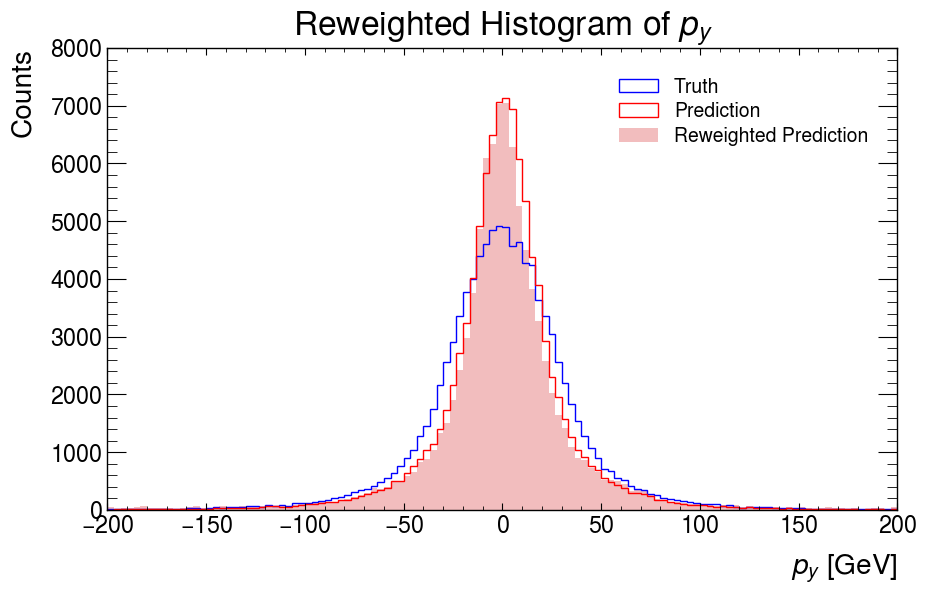

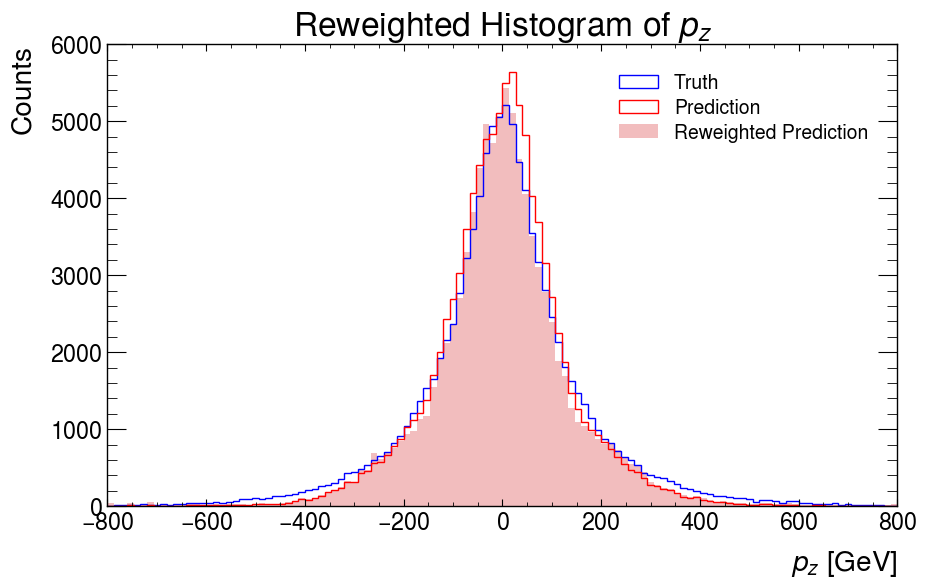

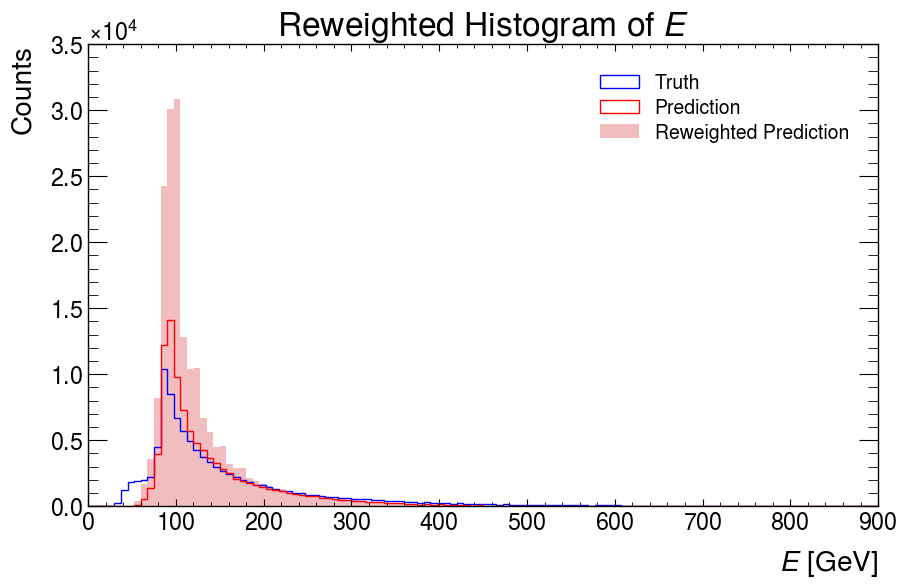

In [26]:
bins_range = (-200, 200)
# Plot the histograms to check numpy hist (py)
truth_hist, truth_bins_edge = np.histogram(
    sig_truth_inv[:, 1], bins=bins_num, range=bins_range, weights=None
)
pred_hist, pred_bins_edge = np.histogram(
    sig_pred_inv[:, 1], bins=bins_num, range=bins_range, weights=None
)
plt.figure(figsize=(10, 6))
hist_info = plt.hist(
    truth_bins_edge[:-1],
    bins=truth_bins_edge,
    weights=truth_hist,
    histtype="step",
    label="Truth",
    color="blue",
)
hist_info = plt.hist(
    pred_bins_edge[:-1],
    bins=pred_bins_edge,
    weights=pred_hist,
    histtype="step",
    label="Prediction",
    color="red",
)
hist_info = plt.hist(
    pred_bins_edge[:-1],
    bins=pred_bins_edge,
    weights=pred_hist * rc,
    histtype="bar",
    label="Reweighted Prediction",
    color="tab:red",
    alpha=0.3,
)
plt.xlabel(r"$p_{y}$ [GeV]")
plt.ylabel("Counts")
plt.title("Reweighted Histogram of $p_{y}$")
plt.legend()
plt.show()

# Plot the histograms to check numpy hist (pz)
bins_range = (-800, 800)
truth_hist, truth_bins_edge = np.histogram(
    sig_truth_inv[:, 2], bins=bins_num, range=bins_range, weights=None
)
pred_hist, pred_bins_edge = np.histogram(
    sig_pred_inv[:, 2], bins=bins_num, range=bins_range, weights=None
)
plt.figure(figsize=(10, 6))
hist_info = plt.hist(
    truth_bins_edge[:-1],
    bins=truth_bins_edge,
    weights=truth_hist,
    histtype="step",
    label="Truth",
    color="blue",
)
hist_info = plt.hist(
    pred_bins_edge[:-1],
    bins=pred_bins_edge,
    weights=pred_hist,
    histtype="step",
    label="Prediction",
    color="red",
)
hist_info = plt.hist(
    pred_bins_edge[:-1],
    bins=pred_bins_edge,
    weights=pred_hist * rc,
    histtype="bar",
    label="Reweighted Prediction",
    color="tab:red",
    alpha=0.3,
)
plt.xlabel(r"$p_{z}$ [GeV]")
plt.ylabel("Counts")
plt.title("Reweighted Histogram of $p_{z}$")
plt.legend()
plt.show()

# Plot the histograms to check numpy hist (energy)
bins_range = (0, 900)
truth_hist, truth_bins_edge = np.histogram(
    sig_truth_inv[:, 3], bins=bins_num, range=bins_range, weights=None
)
pred_hist, pred_bins_edge = np.histogram(
    sig_pred_inv[:, 3], bins=bins_num, range=bins_range, weights=None
)
plt.figure(figsize=(10, 6))
hist_info = plt.hist(
    truth_bins_edge[:-1],
    bins=truth_bins_edge,
    weights=truth_hist,
    histtype="step",
    label="Truth",
    color="blue",
)
hist_info = plt.hist(
    pred_bins_edge[:-1],
    bins=pred_bins_edge,
    weights=pred_hist,
    histtype="step",
    label="Prediction",
    color="red",
)
hist_info = plt.hist(
    pred_bins_edge[:-1],
    bins=pred_bins_edge,
    weights=pred_hist * rc,
    histtype="bar",
    label="Reweighted Prediction",
    color="tab:red",
    alpha=0.3,
)
plt.xlabel(r"$E$ [GeV]")
plt.ylabel("Counts")
plt.title("Reweighted Histogram of $E$")
plt.legend()
plt.show()